# This notebook contains code for plotting the mutation rate as a function of distance from the CDR

In [13]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import numpy as np

In [1]:
# Read in list of pairwise distances per chromosome

# Directory containing CSV files
pairwise_dist_dir = "/private/groups/patenlab/mira/centrolign/batch_submissions/centrolign/release2_QC_v2/all_pairs/distance_matrices/"  # this should be a folder path

# Collect all matching files
files = glob.glob(os.path.join(pairwise_dist_dir, "*_r2_QC_v2_centrolign_pairwise_distance.csv"))

all_dfs = []

for f in files:
    # Extract chr from filename
    # e.g. filename: "chr3_r2_QC_v2_centrolign_pairwise_distance.csv"
    basename = os.path.basename(f)
    chr_val = basename.split("_")[0]   # 'chr3'

    # Read CSV
    df = pd.read_csv(f, header=None,names=["sample1", "sample2", "direct_pairwise_dist","chr"])
    df["chr"] = chr_val
    all_dfs.append(df)

# Combine into one dataframe
all_pairs_dist_df = pd.concat(all_dfs, ignore_index=True)

all_pairs_dist_df.head()

NameError: name 'glob' is not defined

In [15]:
def classify_shape(diff):
    if diff == -1:
        return "triangle"
    elif 0 <= diff <= 0.1:
        return "parallelogram"
    elif diff > 0.1:
        return "trapezoid"
    else:
        return np.nan

### Using SV windows to calculate rates 

In [16]:
def load_matching_beds(chr_str, bed_folder, pairs_df, suffix):

    valid_pairs = {
        frozenset((row.sample1, row.sample2))
        for _, row in pairs_df.iterrows()
    }

    col_indices = [0, 1, 2, 3, 4,5, 6, 7, 8, 9,10,11,12,18]
    col_names = [
        "SV_contig",
        "SV_start",
        "SV_end",
        "par_counts",
        "par_rate",
        "trap_counts",
        "trap_rate",
        "tri_counts",
        "tri_rate",
        "CDR_contig",
        "CDR_start",
        "CDR_end",
        "CDR_status",
        "CDR_distance"
    ]

    all_beds = []

    for fname in os.listdir(bed_folder):

        if not fname.endswith(suffix):
            continue

        base = fname.replace(suffix, "")
        try:
            s1, s2 = base.split("_", 1)
        except ValueError:
            continue

        if frozenset((s1, s2)) not in valid_pairs:
            continue

        bed_path = os.path.join(bed_folder, fname)

        bed_df = pd.read_csv(
            bed_path,
            sep="\t",
            header=None
        )

        #if bed_df.shape[1] <= max(col_indices):
            #print("Unexpected column count:", bed_path, bed_df.shape[1])
            #continue

        # Subset columns
        bed_df = bed_df.iloc[:, col_indices]

        if bed_df.empty:
            continue

        # Add sample metadata
        bed_df.columns = col_names
        bed_df["sample1"] = s1
        bed_df["sample2"] = s2
        bed_df["chr"]=chr_str

        # Check whether all rows have CDR_status == "CDR". Might use this to filter out pairs where one pair doesn't have CDR annotations
        # to make the counts work out 

        both_pairs_CDR = bed_df["CDR_status"].eq("CDR").all()
        bed_df["both_pairs_CDR"] = both_pairs_CDR

        all_beds.append(bed_df)

    if not all_beds:
        return pd.DataFrame()

    return pd.concat(all_beds, ignore_index=True)

In [ ]:
bed_paths="/private/groups/patenlab/mira/centrolign/analysis/variant_dist_CDR/SVs_induced_pairwise/"

# Define chromosomes
chroms = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
#chroms=["chrY"]
all_chrom_dfs = []

for chrom in chroms:

    # Subset pairs dataframe for this chromosome
    pairs_chr_df = all_pairs_dist_df[
        (all_pairs_dist_df["chr"] == chrom) &
        (all_pairs_dist_df["direct_pairwise_dist"] < 0.2)
    ]

    if pairs_chr_df.empty:
        continue
    
    print(f"Processing {chrom}...")
    # Load matching BED data for this chromosome

    chrom_df = load_matching_beds(
        chr_str=chrom,
        bed_folder=bed_paths+chrom,
        pairs_df=pairs_chr_df,
        suffix=".CDR_dist.bed"
    )

    if not chrom_df.empty:
        chrom_df["chr"] = chrom  # optional, but often useful
        all_chrom_dfs.append(chrom_df)

# Concatenate all chromosomes into one DataFrame
final_df = pd.concat(all_chrom_dfs, ignore_index=True)

final_df.head()

Processing chr1...
Processing chr2...
Processing chr3...
Processing chr4...
Processing chr5...
Processing chr6...
Processing chr7...
Processing chr8...
Processing chr9...
Processing chr10...
Processing chr11...
Processing chr12...
Processing chr13...
Processing chr14...
Processing chr15...
Processing chr16...
Processing chr17...
Processing chr18...
Processing chr19...
Processing chr20...
Processing chr21...
Processing chr22...
Processing chrX...
Processing chrY...


SV_contig   SV_start     SV_end  par_counts  par_rate  \
0  HG01123#2#CM089095.1  122533947  122543947           0       0.0   
1  HG01123#2#CM089095.1  122543947  122553947           0       0.0   
2  HG01123#2#CM089095.1  122553947  122563947           0       0.0   
3  HG01123#2#CM089095.1  122563947  122573947           0       0.0   
4  HG01123#2#CM089095.1  122573947  122583947           0       0.0   

   trap_counts  trap_rate  tri_counts  tri_rate            CDR_contig  \
0            0        0.0           0    0.0000  HG01123#2#CM089095.1   
1            0        0.0           1    0.0001  HG01123#2#CM089095.1   
2            0        0.0           0    0.0000  HG01123#2#CM089095.1   
3            0        0.0           0    0.0000  HG01123#2#CM089095.1   
4            0        0.0        3058    0.3058  HG01123#2#CM089095.1   

   CDR_start    CDR_end CDR_status  CDR_distance  sample1    sample2   chr  \
0  123264267  123277330        CDR        720321  HG002.1  HG01123.2  chr1   
1  123264267  123277330        CDR        710321  HG002.1  HG01123.2  chr1   
2  123264267  123277330        CDR        700321  HG002.1  HG01123.2  chr1   
3  123264267  123277330        CDR        690321  HG002.1  HG01123.2  chr1   
4  123264267  123277330        CDR        680321  HG002.1  HG01123.2  chr1   

   both_pairs_CDR  
0           False  
1           False  
2           False  
3           False  
4           False

In [17]:
## Write out dataframe to file
final_df.to_parquet("/private/groups/patenlab/mira/centrolign/analysis/variant_dist_CDR/SVs_induced_pairwise/all_chroms_SV_df.10kb.CDRdist.0.2.parquet")

In [17]:
final_df = pd.read_parquet("/private/groups/patenlab/mira/centrolign/analysis/variant_dist_CDR/SVs_induced_pairwise/all_chroms_SV_df.10kb.CDRdist.0.2.parquet")

In [51]:
# add rate for all variants
final_df["all_counts"] = (
    final_df["par_counts"]
    + final_df["trap_counts"]
    + final_df["tri_counts"]
)

final_df["all_rate"] = final_df["all_counts"] / 10000

# REVERSE CDR COORDS to match neg to upstream and pos to downstream
final_df["CDR_distance"] = -final_df["CDR_distance"]

final_df.head()

SV_contig   SV_start     SV_end  par_counts  par_rate  \
0  HG01123#2#CM089095.1  122533947  122543947           0       0.0   
1  HG01123#2#CM089095.1  122543947  122553947           0       0.0   
2  HG01123#2#CM089095.1  122553947  122563947           0       0.0   
3  HG01123#2#CM089095.1  122563947  122573947           0       0.0   
4  HG01123#2#CM089095.1  122573947  122583947           0       0.0   

   trap_counts  trap_rate  tri_counts  tri_rate            CDR_contig  \
0            0        0.0           0    0.0000  HG01123#2#CM089095.1   
1            0        0.0           1    0.0001  HG01123#2#CM089095.1   
2            0        0.0           0    0.0000  HG01123#2#CM089095.1   
3            0        0.0           0    0.0000  HG01123#2#CM089095.1   
4            0        0.0        3058    0.3058  HG01123#2#CM089095.1   

   CDR_start    CDR_end CDR_status  CDR_distance  sample1    sample2   chr  \
0  123264267  123277330        CDR       -720321  HG002.1  HG01123.2  chr1   
1  123264267  123277330        CDR       -710321  HG002.1  HG01123.2  chr1   
2  123264267  123277330        CDR       -700321  HG002.1  HG01123.2  chr1   
3  123264267  123277330        CDR       -690321  HG002.1  HG01123.2  chr1   
4  123264267  123277330        CDR       -680321  HG002.1  HG01123.2  chr1   

   both_pairs_CDR  all_counts  all_rate  
0           False           0    0.0000  
1           False           1    0.0001  
2           False           0    0.0000  
3           False           0    0.0000  
4           False        3058    0.3058

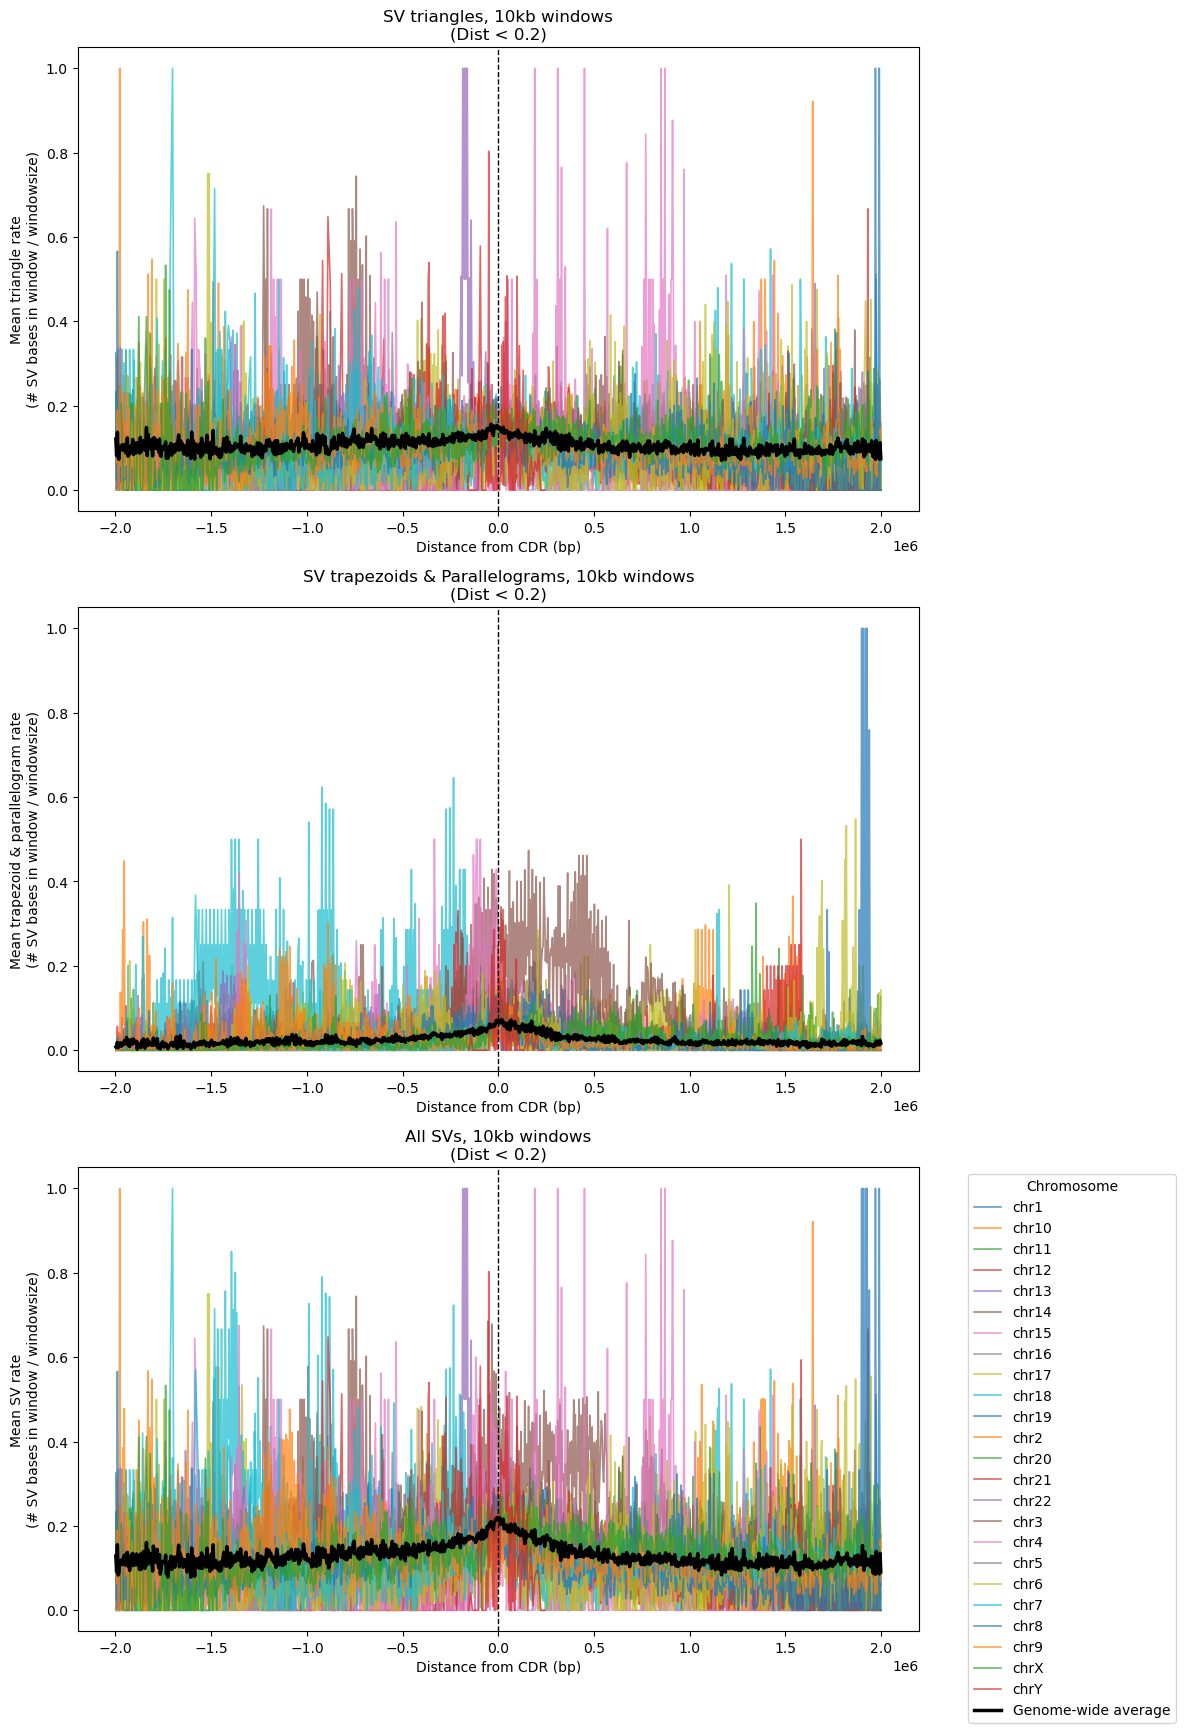

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Define bins and bin centers
window_range = 2_000_000
n_bins = 1000
bin_width = (2 * window_range) / n_bins  # 4000 bp

bin_centers = np.arange(
    -window_range + bin_width / 2,
    window_range,
    bin_width
)

bins = np.concatenate([
    bin_centers - bin_width / 2,
    [bin_centers[-1] + bin_width / 2]
])

# 2. Filter and assign bins
df = final_df[final_df["CDR_start"] != -1].copy()

# combine trap and par rates 
df["trap_par_rate"] = df["trap_rate"] + df["par_rate"]

df["distance_bin"] = pd.cut(
    df["CDR_distance"],
    bins=bins,
    labels=bin_centers,
    include_lowest=True
).astype(float)

# 3. Define rate columns and manual titles
rate_columns = ["tri_rate", "trap_par_rate", "all_rate"]
plot_titles = [
    "SV triangles, 10kb windows\n(Dist < 0.2)",
    "SV trapezoids & Parallelograms, 10kb windows\n(Dist < 0.2)",
    "All SVs, 10kb windows\n(Dist < 0.2)"
]
y_labels = [
    "Mean triangle rate\n(# SV bases in window / windowsize)",
    "Mean trapezoid & parallelogram rate\n(# SV bases in window / windowsize)",
    "Mean SV rate\n(# SV bases in window / windowsize)"
]

# 4. Create subplots
fig, axes = plt.subplots(len(rate_columns), 1, figsize=(12, 18))

for ax, rate_col, title, y_label in zip(axes, rate_columns, plot_titles, y_labels):

    # Aggregate per chromosome
    agg = (
        df
        .groupby(["chr", "distance_bin"], as_index=False)
        .agg(mean_rate=(rate_col, "mean"))
    )

    # Aggregate genome-wide
    genome_avg = (
        df
        .groupby("distance_bin", as_index=False)
        .agg(mean_rate=(rate_col, "mean"))
        .sort_values("distance_bin")
    )

    # Per-chromosome lines
    for chrom, chrom_df in agg.groupby("chr"):
        chrom_df = chrom_df.sort_values("distance_bin")
        ax.plot(
            chrom_df["distance_bin"],
            chrom_df["mean_rate"],
            label=str(chrom),
            linewidth=1.2,
            alpha=0.7
        )

    # Genome-wide average (black, thick, on top)
    ax.plot(
        genome_avg["distance_bin"],
        genome_avg["mean_rate"],
        color="black",
        linewidth=2.5,
        label="Genome-wide average",
        zorder=10
    )

    ax.axvline(0, color="black", linestyle="--", linewidth=1)
    ax.set_ylabel(y_label)
    ax.set_xlabel("Distance from CDR (bp)")
    ax.set_title(title)  # Manually set title here

# Legend on the last subplot
axes[-1].legend(title="Chromosome", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


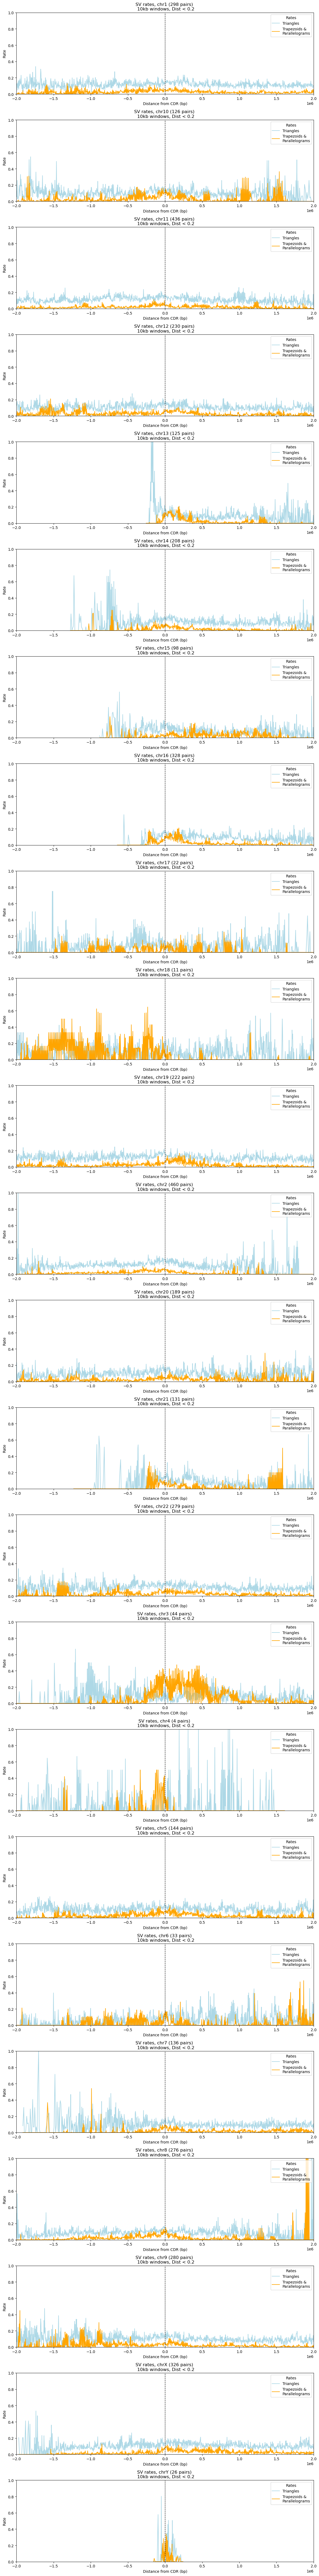

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Filter for valid CDR positions
df = final_df[final_df["CDR_start"] != -1].copy()

# combine trap and par rates 
df["trap_par_rate"] = df["trap_rate"] + df["par_rate"]

# Define bins and bin centers
window_range = 2_000_000
n_bins = 1000
bin_width = (2 * window_range) / n_bins

bin_centers = np.arange(
    -window_range + bin_width / 2,
    window_range,
    bin_width
)

bins = np.concatenate([
    bin_centers - bin_width / 2,
    [bin_centers[-1] + bin_width / 2]
])

# Assign each row to a distance bin
df["distance_bin"] = pd.cut(
    df["CDR_distance"],
    bins=bins,
    labels=bin_centers,
    include_lowest=True
).astype(float)

# List of chromosomes
chromosomes = sorted(df["chr"].unique())

# Assign a color to each rate
rate_colors = {
    "tri_rate": "lightblue",
    "trap_par_rate": "orange"
}
legend_labels = {
    "tri_rate": "Triangles",
    "trap_par_rate": "Trapezoids &\nParallelograms"
}
# Count unique sample pairs per chromosome
pair_counts = (
    df[["chr", "sample1", "sample2"]]
    .drop_duplicates()
    .groupby("chr")
    .size()
    .to_dict()
)

# Create subplots: one panel per chromosome
fig, axes = plt.subplots(len(chromosomes), 1, figsize=(12, 4 * len(chromosomes)))

if len(chromosomes) == 1:
    axes = [axes]

for ax, chrom in zip(axes, chromosomes):
    chrom_df = df[df["chr"] == chrom]

    # Plot TRI, TRAP, PAR rates
    for rate_col in ["tri_rate", "trap_par_rate"]:
        agg = (
            chrom_df
            .groupby("distance_bin", as_index=False)
            .agg(mean_rate=(rate_col, "mean"))
            .sort_values("distance_bin")
        )
        ax.plot(
            agg["distance_bin"],
            agg["mean_rate"],
            color=rate_colors[rate_col],
            linewidth=1.5,
            label=legend_labels[rate_col]  # renamed
        )

    # Plot ALL rate in black, thicker line
    agg_all = (
        chrom_df
        .groupby("distance_bin", as_index=False)
        .agg(mean_rate=("all_rate", "mean"))
        .sort_values("distance_bin")
    )
    # ax.plot(
    #     agg_all["distance_bin"],
    #     agg_all["mean_rate"],
    #     color=rate_colors["all_rate"],
    #     linewidth=1.5,
    #     label="All Rate",
    #     zorder=10
    # )

    # Vertical line at CDR
    ax.axvline(0, color="black", linestyle="--", linewidth=1)

    # Axis limits, labels, title
    ax.set_ylim(0, 1)
    ax.set_xlim(-2000000, 2000000)
    ax.set_ylabel("Rate")
    n_pairs = pair_counts.get(chrom, 0)
    ax.set_title(f"SV rates, {chrom} ({n_pairs} pairs) \n 10kb windows, Dist < 0.2")
    ax.legend(title="Rates", loc="upper right")

# x-axis label for the bottom panel
    ax.set_xlabel("Distance from CDR (bp)")

# Legend on the top panel
#axes[0].legend(title="Rates", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


### Short indels mutation rate - 1kb windows

In [26]:
bed_paths="/private/groups/patenlab/mira/centrolign/analysis/variant_dist_CDR/short_indels_pairwise/1kb/"

# Define chromosomes
chroms = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
#chroms=["chrY"]
all_chrom_dfs = []

for chrom in chroms:

    # Subset pairs dataframe for this chromosome
    pairs_chr_df = all_pairs_dist_df[
        (all_pairs_dist_df["chr"] == chrom) &
        (all_pairs_dist_df["direct_pairwise_dist"] < 0.2)
    ]

    if pairs_chr_df.empty:
        continue
    
    print(f"Processing {chrom}...")
    # Load matching BED data for this chromosome

    chrom_df = load_matching_beds(
        chr_str=chrom,
        bed_folder=bed_paths+chrom,
        pairs_df=pairs_chr_df,
        suffix=".CDR_dist.1kb.bed"
    )

    if not chrom_df.empty:
        chrom_df["chr"] = chrom  # optional, but often useful
        all_chrom_dfs.append(chrom_df)

# Concatenate all chromosomes into one DataFrame
final_short_indel_df = pd.concat(all_chrom_dfs, ignore_index=True)

final_short_indel_df.head()

Processing chr1...
Processing chr2...
Processing chr3...
Processing chr4...
Processing chr5...
Processing chr6...
Processing chr7...
Processing chr8...
Processing chr9...
Processing chr10...
Processing chr11...
Processing chr12...
Processing chr13...
Processing chr14...
Processing chr15...
Processing chr16...
Processing chr17...
Processing chr18...
Processing chr19...
Processing chr20...
Processing chr21...
Processing chr22...
Processing chrX...
Processing chrY...


SV_contig   SV_start     SV_end  par_counts  par_rate  \
0  HG01175#2#JAHALZ020000037.1  121382494  121383494           0       0.0   
1  HG01175#2#JAHALZ020000037.1  121383494  121384494           0       0.0   
2  HG01175#2#JAHALZ020000037.1  121384494  121385494           0       0.0   
3  HG01175#2#JAHALZ020000037.1  121385494  121386494           0       0.0   
4  HG01175#2#JAHALZ020000037.1  121386494  121387494           0       0.0   

   trap_counts  trap_rate  tri_counts  tri_rate                   CDR_contig  \
0            0        0.0           0       0.0  HG01175#2#JAHALZ020000037.1   
1            0        0.0           0       0.0  HG01175#2#JAHALZ020000037.1   
2            0        0.0           0       0.0  HG01175#2#JAHALZ020000037.1   
3            0        0.0           0       0.0  HG01175#2#JAHALZ020000037.1   
4            0        0.0           0       0.0  HG01175#2#JAHALZ020000037.1   

   CDR_start    CDR_end CDR_status  CDR_distance    sample1    sample2   chr  \
0  122083249  122092322        CDR        699756  HG01175.2  NA19159.2  chr1   
1  122083249  122092322        CDR        698756  HG01175.2  NA19159.2  chr1   
2  122083249  122092322        CDR        697756  HG01175.2  NA19159.2  chr1   
3  122083249  122092322        CDR        696756  HG01175.2  NA19159.2  chr1   
4  122083249  122092322        CDR        695756  HG01175.2  NA19159.2  chr1   

   both_pairs_CDR  
0           False  
1           False  
2           False  
3           False  
4           False

In [54]:
# add rate for all variants
final_short_indel_df["all_counts"] = (
    final_short_indel_df["par_counts"]
    + final_short_indel_df["trap_counts"]
    + final_short_indel_df["tri_counts"]
)

# REVERSE CDR COORDS to match neg to upstream and pos to downstream
final_short_indel_df["CDR_distance"] = -final_short_indel_df["CDR_distance"]

final_short_indel_df["all_rate"] = final_short_indel_df["all_counts"] / 1000
final_short_indel_df.head()

SV_contig   SV_start     SV_end  par_counts  par_rate  \
0  HG01175#2#JAHALZ020000037.1  121382494  121383494           0       0.0   
1  HG01175#2#JAHALZ020000037.1  121383494  121384494           0       0.0   
2  HG01175#2#JAHALZ020000037.1  121384494  121385494           0       0.0   
3  HG01175#2#JAHALZ020000037.1  121385494  121386494           0       0.0   
4  HG01175#2#JAHALZ020000037.1  121386494  121387494           0       0.0   

   trap_counts  trap_rate  tri_counts  tri_rate                   CDR_contig  \
0            0        0.0           0       0.0  HG01175#2#JAHALZ020000037.1   
1            0        0.0           0       0.0  HG01175#2#JAHALZ020000037.1   
2            0        0.0           0       0.0  HG01175#2#JAHALZ020000037.1   
3            0        0.0           0       0.0  HG01175#2#JAHALZ020000037.1   
4            0        0.0           0       0.0  HG01175#2#JAHALZ020000037.1   

   CDR_start    CDR_end CDR_status  CDR_distance    sample1    sample2   chr  \
0  122083249  122092322        CDR       -699756  HG01175.2  NA19159.2  chr1   
1  122083249  122092322        CDR       -698756  HG01175.2  NA19159.2  chr1   
2  122083249  122092322        CDR       -697756  HG01175.2  NA19159.2  chr1   
3  122083249  122092322        CDR       -696756  HG01175.2  NA19159.2  chr1   
4  122083249  122092322        CDR       -695756  HG01175.2  NA19159.2  chr1   

   both_pairs_CDR  all_counts  all_rate  
0           False           0       0.0  
1           False           0       0.0  
2           False           0       0.0  
3           False           0       0.0  
4           False           0       0.0

In [27]:
# Assuming your DataFrame is named 'df'
count_nonzero = (final_short_indel_df['tri_rate'] != 0).sum()
print(count_nonzero)


246505


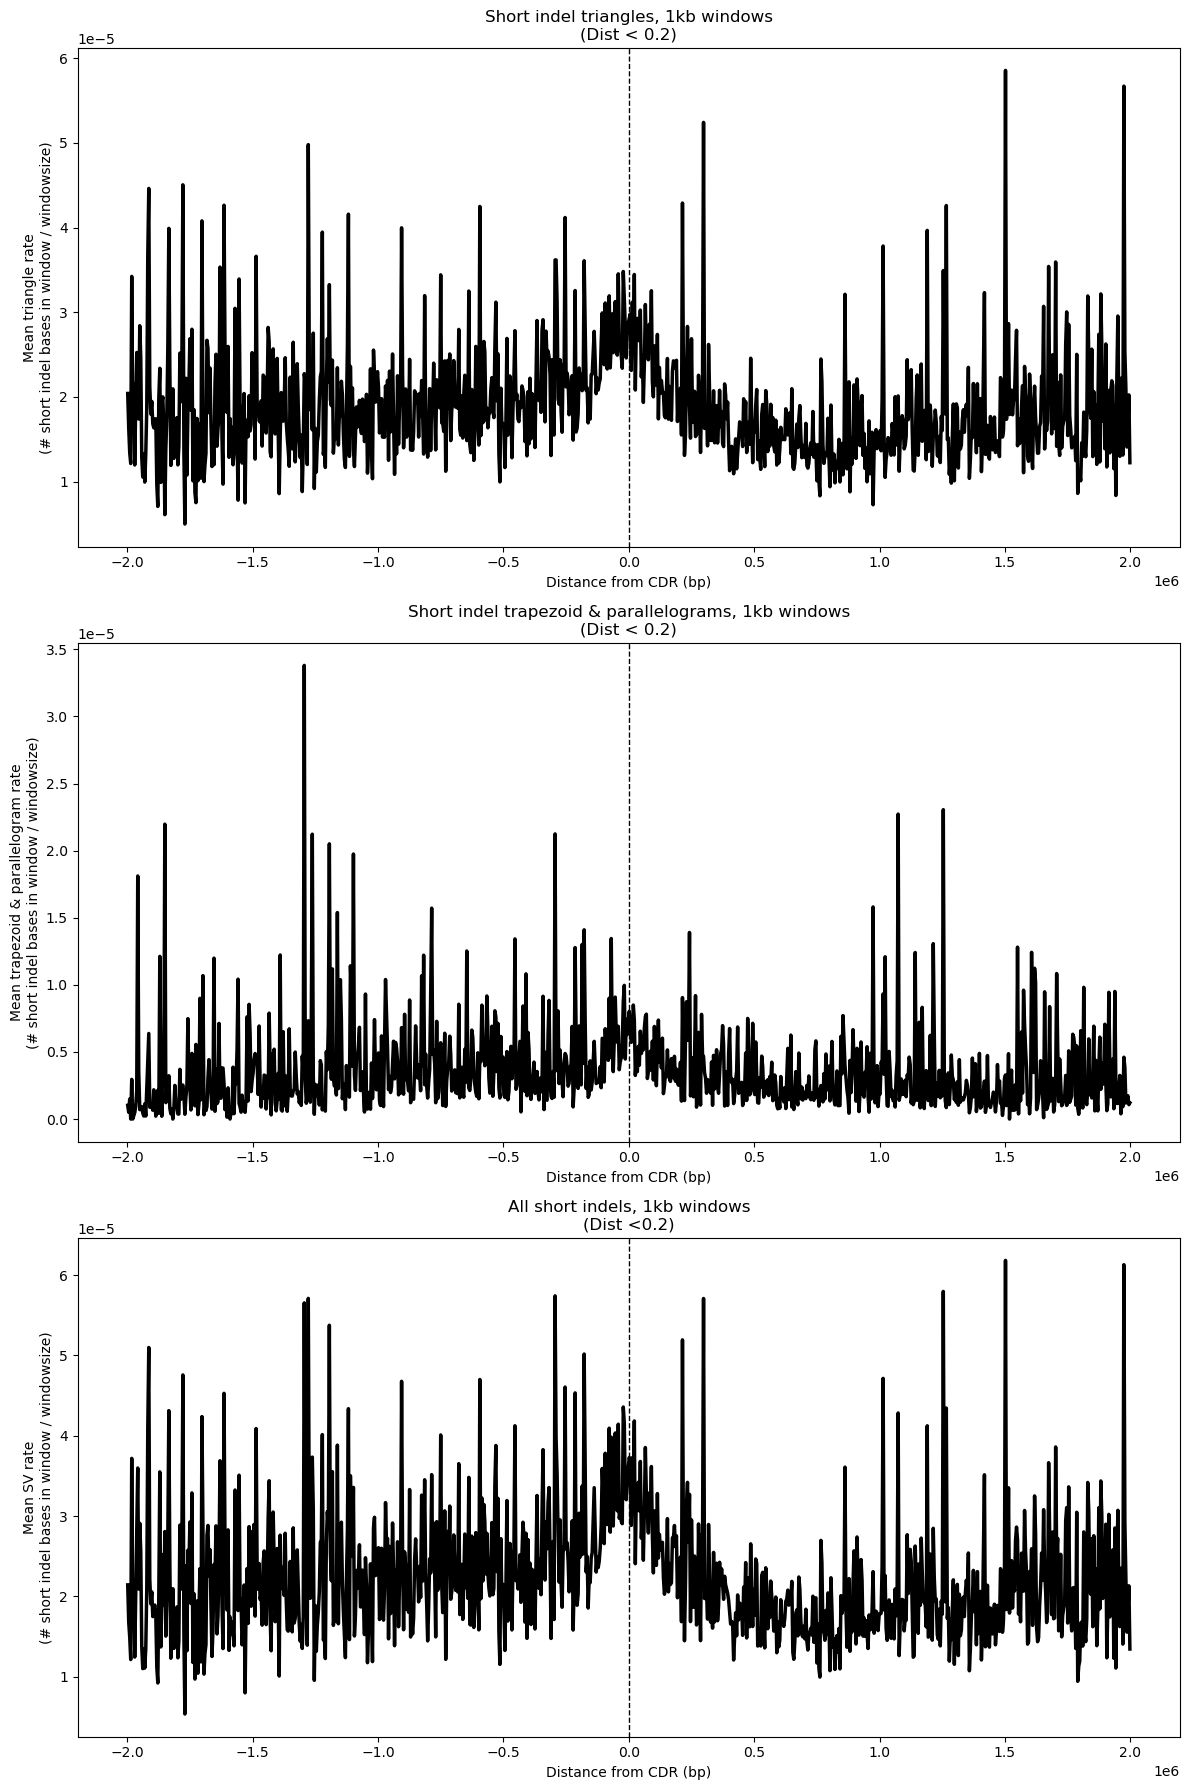

In [55]:
### Short indels mutation rate - 1000bp windows
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Define bins and bin centers
window_range = 2_000_000
n_bins = 1000
bin_width = (2 * window_range) / n_bins  # 4000 bp

bin_centers = np.arange(
    -window_range + bin_width / 2,
    window_range,
    bin_width
)

bins = np.concatenate([
    bin_centers - bin_width / 2,
    [bin_centers[-1] + bin_width / 2]
])

# 2. Filter and assign bins
df = final_short_indel_df[final_short_indel_df["CDR_start"] != -1].copy()

# combine trap and par rates 
df["trap_par_rate"] = df["trap_rate"] + df["par_rate"]

df["distance_bin"] = pd.cut(
    df["CDR_distance"],
    bins=bins,
    labels=bin_centers,
    include_lowest=True
).astype(float)

# 3. Define rate columns and titles
rate_columns = ["tri_rate", "trap_par_rate", "all_rate"]
plot_titles = [
    "Short indel triangles, 1kb windows\n(Dist < 0.2)",
    "Short indel trapezoid & parallelograms, 1kb windows\n(Dist < 0.2)",
    "All short indels, 1kb windows\n(Dist <0.2)"
]
y_labels = [
    "Mean triangle rate\n(# short indel bases in window / windowsize)",
    "Mean trapezoid & parallelogram rate\n(# short indel bases in window / windowsize)",
    "Mean SV rate\n(# short indel bases in window / windowsize)"
]

# 4. Create subplots
fig, axes = plt.subplots(len(rate_columns), 1, figsize=(12, 18))

for ax, rate_col, title, y_label in zip(axes, rate_columns, plot_titles, y_labels):

    # Genome-wide average only
    genome_avg = (
        df
        .groupby("distance_bin", as_index=False)
        .agg(mean_rate=(rate_col, "mean"))
        .sort_values("distance_bin")
    )

    ax.plot(
        genome_avg["distance_bin"],
        genome_avg["mean_rate"],
        color="black",
        linewidth=2.5
    )

    ax.axvline(0, color="black", linestyle="--", linewidth=1)
    ax.set_ylabel(y_label)
    ax.set_xlabel("Distance from CDR (bp)")
    ax.set_title(title)

plt.tight_layout()
plt.show()


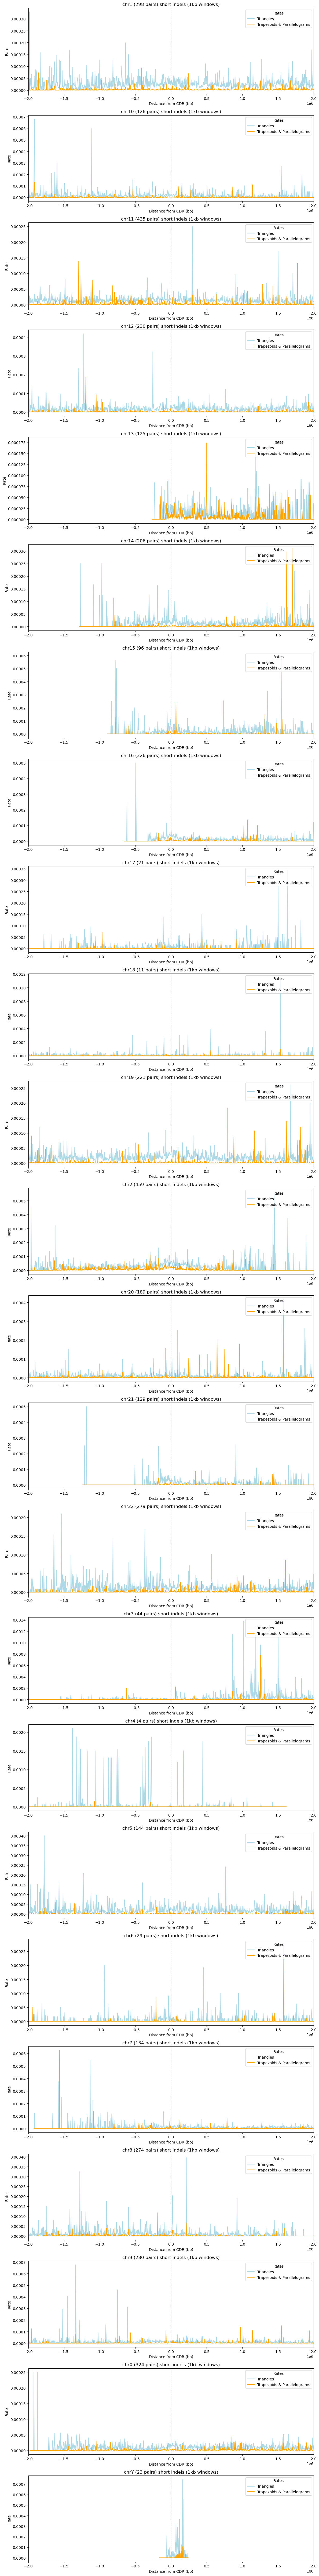

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Filter for valid CDR positions
df = final_short_indel_df[final_short_indel_df["CDR_start"] != -1].copy()

# combine trap and par rates 
df["trap_par_rate"] = df["trap_rate"] + df["par_rate"]

# Define bins and bin centers
window_range = 2_000_000
n_bins = 1000
bin_width = (2 * window_range) / n_bins

bin_centers = np.arange(
    -window_range + bin_width / 2,
    window_range,
    bin_width
)

bins = np.concatenate([
    bin_centers - bin_width / 2,
    [bin_centers[-1] + bin_width / 2]
])

# Assign each row to a distance bin
df["distance_bin"] = pd.cut(
    df["CDR_distance"],
    bins=bins,
    labels=bin_centers,
    include_lowest=True
).astype(float)

# List of chromosomes
chromosomes = sorted(df["chr"].unique())

# Assign a color to each rate
rate_colors = {
    "tri_rate": "lightblue",
    "trap_par_rate": "orange"
}
legend_labels = {
    "tri_rate": "Triangles",
    "trap_par_rate": "Trapezoids & Parallelograms"
}
# Count unique sample pairs per chromosome
pair_counts = (
    df[["chr", "sample1", "sample2"]]
    .drop_duplicates()
    .groupby("chr")
    .size()
    .to_dict()
)

# Create subplots: one panel per chromosome
fig, axes = plt.subplots(len(chromosomes), 1, figsize=(12, 4 * len(chromosomes)))

if len(chromosomes) == 1:
    axes = [axes]

for ax, chrom in zip(axes, chromosomes):
    chrom_df = df[df["chr"] == chrom]

    # Plot TRI, TRAP, PAR rates
    for rate_col in ["tri_rate", "trap_par_rate"]:
        agg = (
            chrom_df
            .groupby("distance_bin", as_index=False)
            .agg(mean_rate=(rate_col, "mean"))
            .sort_values("distance_bin")
        )
        ax.plot(
            agg["distance_bin"],
            agg["mean_rate"],
            color=rate_colors[rate_col],
            linewidth=1.5,
            label=legend_labels[rate_col]  # renamed
        )

    # Plot ALL rate in black, thicker line
    agg_all = (
        chrom_df
        .groupby("distance_bin", as_index=False)
        .agg(mean_rate=("all_rate", "mean"))
        .sort_values("distance_bin")
    )
    # ax.plot(
    #     agg_all["distance_bin"],
    #     agg_all["mean_rate"],
    #     color=rate_colors["all_rate"],
    #     linewidth=1.5,
    #     label="All Rate",
    #     zorder=10
    # )

    # Vertical line at CDR
    ax.axvline(0, color="black", linestyle="--", linewidth=1)

    # Axis limits, labels, title
    ax.set_xlim(-2000000, 2000000)
    ax.set_ylabel("Rate")
    n_pairs = pair_counts.get(chrom, 0)
    ax.set_title(f"{chrom} ({n_pairs} pairs) short indels (1kb windows)")
    ax.legend(title="Rates", loc="upper right")

# x-axis label for the bottom panel
    ax.set_xlabel("Distance from CDR (bp)")

# Legend on the top panel
#axes[0].legend(title="Rates", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

### Short indels, 100 bp windows

In [10]:
bed_paths="/private/groups/patenlab/mira/centrolign/analysis/variant_dist_CDR/short_indels_pairwise/100bp/"

# Define chromosomes
chroms = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
#chroms=["chrY"]
all_chrom_dfs = []

for chrom in chroms:

    # Subset pairs dataframe for this chromosome
    pairs_chr_df = all_pairs_dist_df[
        (all_pairs_dist_df["chr"] == chrom) &
        (all_pairs_dist_df["direct_pairwise_dist"] < 0.2)
    ]

    if pairs_chr_df.empty:
        continue
    
    print(f"Processing {chrom}...")
    # Load matching BED data for this chromosome

    chrom_df = load_matching_beds(
        chr_str=chrom,
        bed_folder=bed_paths+chrom,
        pairs_df=pairs_chr_df,
        suffix=".CDR_dist.100bp.bed"
    )

    if not chrom_df.empty:
        chrom_df["chr"] = chrom  # optional, but often useful
        all_chrom_dfs.append(chrom_df)

# Concatenate all chromosomes into one DataFrame
final_short_indel_100bp_df = pd.concat(all_chrom_dfs, ignore_index=True)

final_short_indel_100bp_df.head()

Processing chr1...


/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype opti

Processing chr2...


/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype opti

Processing chr3...


/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype opti

Processing chr4...
Processing chr5...


/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype opti

Processing chr6...


/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(


Processing chr7...


/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype opti

Processing chr8...


/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype opti

Processing chr9...


/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype opti

Processing chr10...


/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype opti

Processing chr11...


/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype opti

Processing chr12...


/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype opti

Processing chr13...


/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(


Processing chr14...


/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype opti

Processing chr15...


/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype opti

Processing chr16...


/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype opti

Processing chr17...


/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(


Processing chr18...


/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(


Processing chr19...


/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype opti

Processing chr20...


/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype opti

Processing chr21...


/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(


Processing chr22...


/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype opti

Processing chrX...


/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1868033/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype opti

Processing chrY...


SV_contig   SV_start     SV_end  par_counts  par_rate  \
0  HG01255#2#CM086717.1  121942440  121942540           0       0.0   
1  HG01255#2#CM086717.1  121942540  121942640           0       0.0   
2  HG01255#2#CM086717.1  121942640  121942740           0       0.0   
3  HG01255#2#CM086717.1  121942740  121942840           0       0.0   
4  HG01255#2#CM086717.1  121942840  121942940           0       0.0   

   trap_counts  trap_rate  tri_counts  tri_rate            CDR_contig  \
0            0        0.0           0       0.0  HG01255#2#CM086717.1   
1            0        0.0           0       0.0  HG01255#2#CM086717.1   
2            0        0.0           0       0.0  HG01255#2#CM086717.1   
3            0        0.0           0       0.0  HG01255#2#CM086717.1   
4            0        0.0           0       0.0  HG01255#2#CM086717.1   

   CDR_start    CDR_end CDR_status  CDR_distance    sample1    sample2   chr  \
0  122985782  123091784        CDR       1043243  HG02004.1  HG01255.2  chr1   
1  122985782  123091784        CDR       1043143  HG02004.1  HG01255.2  chr1   
2  122985782  123091784        CDR       1043043  HG02004.1  HG01255.2  chr1   
3  122985782  123091784        CDR       1042943  HG02004.1  HG01255.2  chr1   
4  122985782  123091784        CDR       1042843  HG02004.1  HG01255.2  chr1   

   both_pairs_CDR  
0            True  
1            True  
2            True  
3            True  
4            True

In [57]:
# add rate for all variants
final_short_indel_100bp_df["all_counts"] = (
    final_short_indel_100bp_df["par_counts"]
    + final_short_indel_100bp_df["trap_counts"]
    + final_short_indel_100bp_df["tri_counts"]
)

# REVERSE CDR COORDS to match neg to upstream and pos to downstream
final_short_indel_100bp_df["CDR_distance"] = -final_short_indel_100bp_df["CDR_distance"]

final_short_indel_100bp_df["all_rate"] = final_short_indel_100bp_df["all_counts"] / 100
final_short_indel_100bp_df.head()

NameError: name 'final_short_indel_100bp_df' is not defined

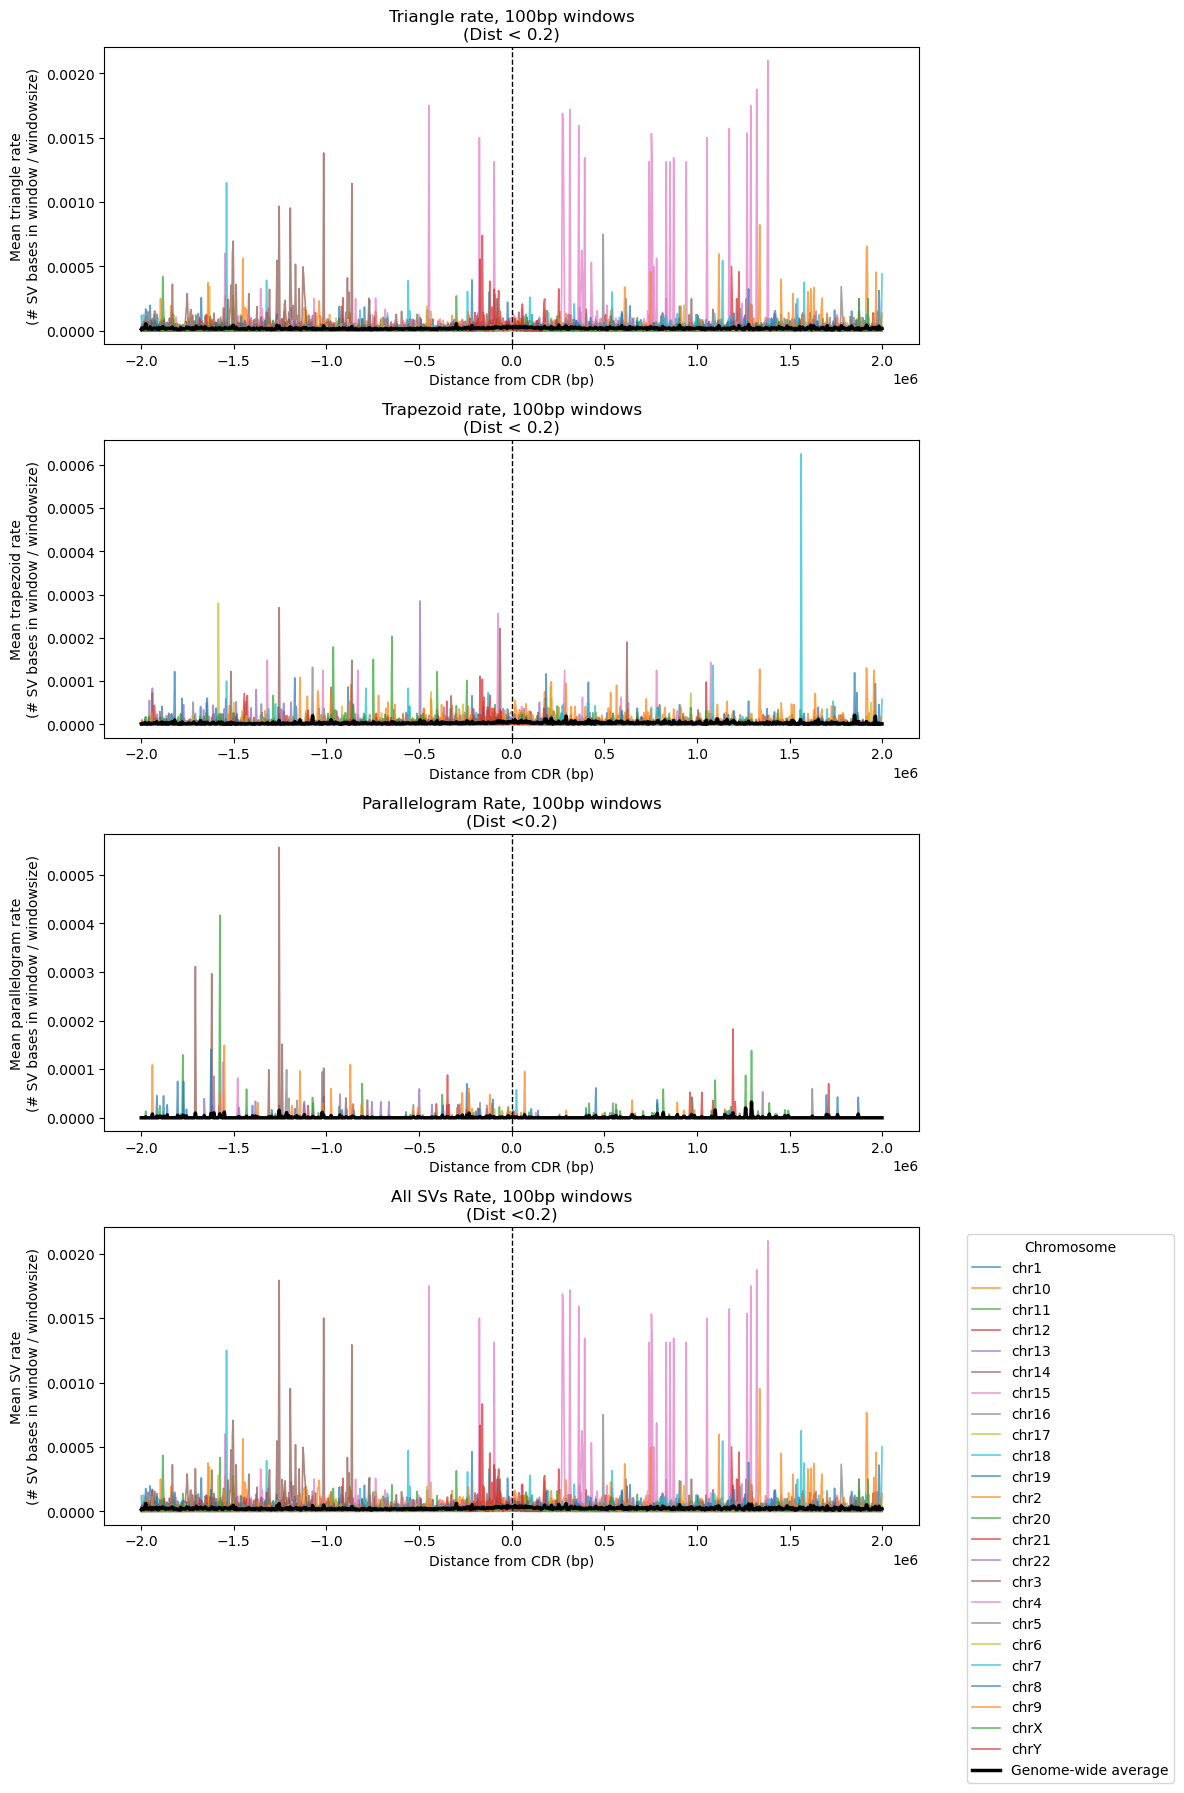

In [30]:
### Short indels mutation rate - 100bp windows
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Define bins and bin centers
window_range = 2_000_000
n_bins = 1000
bin_width = (2 * window_range) / n_bins  # 4000 bp

bin_centers = np.arange(
    -window_range + bin_width / 2,
    window_range,
    bin_width
)

bins = np.concatenate([
    bin_centers - bin_width / 2,
    [bin_centers[-1] + bin_width / 2]
])

# 2. Filter and assign bins
df = final_short_indel_100bp_df[final_short_indel_100bp_df["CDR_start"] != -1].copy()

df["distance_bin"] = pd.cut(
    df["CDR_distance"],
    bins=bins,
    labels=bin_centers,
    include_lowest=True
).astype(float)

# 3. Define rate columns and manual titles
rate_columns = ["tri_rate", "trap_rate", "par_rate", "all_rate"]
plot_titles = ["Triangle rate, 100bp windows\n(Dist < 0.2)", "Trapezoid rate, 100bp windows\n(Dist < 0.2)", "Parallelogram Rate, 100bp windows\n(Dist <0.2)", "All SVs Rate, 100bp windows\n(Dist <0.2)"]
y_labels = ["Mean triangle rate\n(# SV bases in window / windowsize)", "Mean trapezoid rate\n(# SV bases in window / windowsize)", "Mean parallelogram rate\n(# SV bases in window / windowsize)", "Mean SV rate\n(# SV bases in window / windowsize)"]

# 4. Create subplots
fig, axes = plt.subplots(len(rate_columns), 1, figsize=(12, 18))

for ax, rate_col, title, y_label in zip(axes, rate_columns, plot_titles, y_labels):

    # Aggregate per chromosome
    agg = (
        df
        .groupby(["chr", "distance_bin"], as_index=False)
        .agg(mean_rate=(rate_col, "mean"))
    )

    # Aggregate genome-wide
    genome_avg = (
        df
        .groupby("distance_bin", as_index=False)
        .agg(mean_rate=(rate_col, "mean"))
        .sort_values("distance_bin")
    )

    # Per-chromosome lines
    for chrom, chrom_df in agg.groupby("chr"):
        chrom_df = chrom_df.sort_values("distance_bin")
        ax.plot(
            chrom_df["distance_bin"],
            chrom_df["mean_rate"],
            label=str(chrom),
            linewidth=1.2,
            alpha=0.7
        )

    # Genome-wide average (black, thick, on top)
    ax.plot(
        genome_avg["distance_bin"],
        genome_avg["mean_rate"],
        color="black",
        linewidth=2.5,
        label="Genome-wide average",
        zorder=10
    )

    ax.axvline(0, color="black", linestyle="--", linewidth=1)
    ax.set_ylabel(y_label)
    ax.set_xlabel("Distance from CDR (bp)")
    ax.set_title(title)  # Manually set title here

# Legend on the last subplot
axes[-1].legend(title="Chromosome", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig('short_indel.png') 
plt.show()


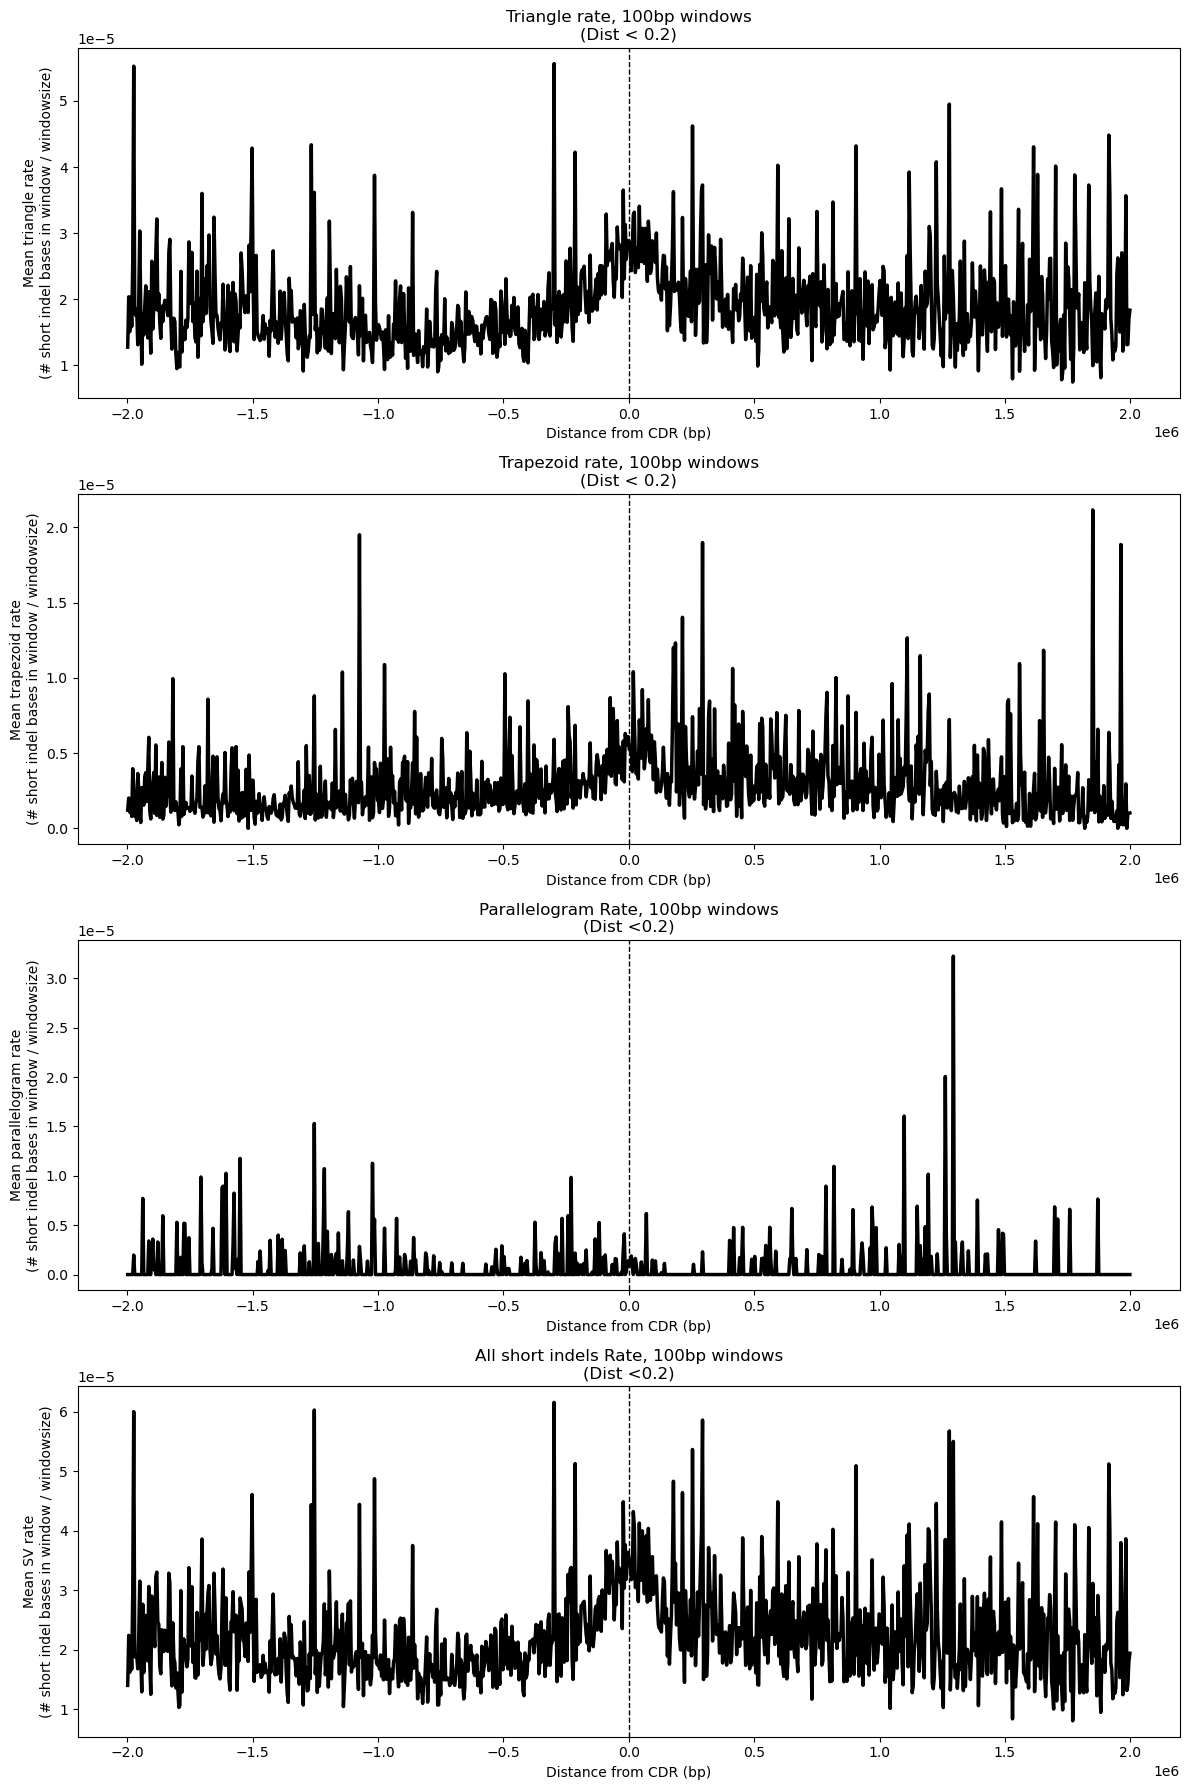

In [31]:
### Short indels mutation rate - 100bp windows
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Define bins and bin centers
window_range = 2_000_000
n_bins = 1000
bin_width = (2 * window_range) / n_bins  # 4000 bp

bin_centers = np.arange(
    -window_range + bin_width / 2,
    window_range,
    bin_width
)

bins = np.concatenate([
    bin_centers - bin_width / 2,
    [bin_centers[-1] + bin_width / 2]
])

# 2. Filter and assign bins
df = final_short_indel_100bp_df[final_short_indel_100bp_df["CDR_start"] != -1].copy()

df["distance_bin"] = pd.cut(
    df["CDR_distance"],
    bins=bins,
    labels=bin_centers,
    include_lowest=True
).astype(float)

# 3. Define rate columns and titles
rate_columns = ["tri_rate", "trap_rate", "par_rate", "all_rate"]
plot_titles = [
    "Triangle rate, 100bp windows\n(Dist < 0.2)",
    "Trapezoid rate, 100bp windows\n(Dist < 0.2)",
    "Parallelogram Rate, 100bp windows\n(Dist <0.2)",
    "All short indels Rate, 100bp windows\n(Dist <0.2)"
]
y_labels = [
    "Mean triangle rate\n(# short indel bases in window / windowsize)",
    "Mean trapezoid rate\n(# short indel bases in window / windowsize)",
    "Mean parallelogram rate\n(# short indel bases in window / windowsize)",
    "Mean SV rate\n(# short indel bases in window / windowsize)"
]

# 4. Create subplots
fig, axes = plt.subplots(len(rate_columns), 1, figsize=(12, 18))

for ax, rate_col, title, y_label in zip(axes, rate_columns, plot_titles, y_labels):

    # Genome-wide average only
    genome_avg = (
        df
        .groupby("distance_bin", as_index=False)
        .agg(mean_rate=(rate_col, "mean"))
        .sort_values("distance_bin")
    )

    ax.plot(
        genome_avg["distance_bin"],
        genome_avg["mean_rate"],
        color="black",
        linewidth=2.5
    )

    ax.axvline(0, color="black", linestyle="--", linewidth=1)
    ax.set_ylabel(y_label)
    ax.set_xlabel("Distance from CDR (bp)")
    ax.set_title(title)

plt.tight_layout()
plt.savefig("short_indel.png")
plt.show()


### Short indels, 10kb windows

In [20]:
bed_paths="/private/groups/patenlab/mira/centrolign/analysis/variant_dist_CDR/short_indels_pairwise/10kb/"

# Define chromosomes
chroms = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
#chroms=["chrY"]
all_chrom_dfs = []

for chrom in chroms:

    # Subset pairs dataframe for this chromosome
    pairs_chr_df = all_pairs_dist_df[
        (all_pairs_dist_df["chr"] == chrom) &
        (all_pairs_dist_df["direct_pairwise_dist"] < 0.2)
    ]

    if pairs_chr_df.empty:
        continue
    
    print(f"Processing {chrom}...")
    # Load matching BED data for this chromosome

    chrom_df = load_matching_beds(
        chr_str=chrom,
        bed_folder=bed_paths+chrom,
        pairs_df=pairs_chr_df,
        suffix=".CDR_dist.10kb.bed"
    )

    if not chrom_df.empty:
        chrom_df["chr"] = chrom  # optional, but often useful
        all_chrom_dfs.append(chrom_df)

# Concatenate all chromosomes into one DataFrame
final_short_indel_10kb_df = pd.concat(all_chrom_dfs, ignore_index=True)

final_short_indel_10kb_df.head()

Processing chr1...
Processing chr2...
Processing chr3...
Processing chr4...
Processing chr5...
Processing chr6...
Processing chr7...
Processing chr8...
Processing chr9...
Processing chr10...
Processing chr11...
Processing chr12...
Processing chr13...
Processing chr14...
Processing chr15...
Processing chr16...
Processing chr17...
Processing chr18...
Processing chr19...
Processing chr20...
Processing chr21...
Processing chr22...
Processing chrX...
Processing chrY...


SV_contig   SV_start     SV_end  par_counts  par_rate  \
0  HG01943#1#JBHIIK010000013.1  122330268  122340268           0       0.0   
1  HG01943#1#JBHIIK010000013.1  122340268  122350268           0       0.0   
2  HG01943#1#JBHIIK010000013.1  122350268  122360268           0       0.0   
3  HG01943#1#JBHIIK010000013.1  122360268  122370268           0       0.0   
4  HG01943#1#JBHIIK010000013.1  122370268  122380268           0       0.0   

   trap_counts  trap_rate  tri_counts  tri_rate                   CDR_contig  \
0            0        0.0           0       0.0  HG01943#1#JBHIIK010000013.1   
1            0        0.0           0       0.0  HG01943#1#JBHIIK010000013.1   
2            0        0.0           0       0.0  HG01943#1#JBHIIK010000013.1   
3            0        0.0           0       0.0  HG01943#1#JBHIIK010000013.1   
4            0        0.0           0       0.0  HG01943#1#JBHIIK010000013.1   

   CDR_start    CDR_end CDR_status  CDR_distance    sample1    sample2   chr  \
0  122783555  122809005        CDR        443288  HG02148.2  HG01943.1  chr1   
1  122783555  122809005        CDR        433288  HG02148.2  HG01943.1  chr1   
2  122783555  122809005        CDR        423288  HG02148.2  HG01943.1  chr1   
3  122783555  122809005        CDR        413288  HG02148.2  HG01943.1  chr1   
4  122783555  122809005        CDR        403288  HG02148.2  HG01943.1  chr1   

   both_pairs_CDR  
0           False  
1           False  
2           False  
3           False  
4           False

In [ ]:
# add rate for all variants
final_short_indel_10kb_df["all_counts"] = (
    final_short_indel_10kb_df["par_counts"]
    + final_short_indel_10kb_df["trap_counts"]
    + final_short_indel_10kb_df["tri_counts"]
)

# REVERSE CDR COORDS to match neg to upstream and pos to downstream
final_short_indel_10kb_df["CDR_distance"] = -final_short_indel_10kb_df["CDR_distance"]

final_short_indel_10kb_df["all_rate"] = final_short_indel_10kb_df["all_counts"] / 10000
final_short_indel_10kb_df.head()

SV_contig   SV_start     SV_end  par_counts  par_rate  \
0  HG01943#1#JBHIIK010000013.1  122330268  122340268           0       0.0   
1  HG01943#1#JBHIIK010000013.1  122340268  122350268           0       0.0   
2  HG01943#1#JBHIIK010000013.1  122350268  122360268           0       0.0   
3  HG01943#1#JBHIIK010000013.1  122360268  122370268           0       0.0   
4  HG01943#1#JBHIIK010000013.1  122370268  122380268           0       0.0   

   trap_counts  trap_rate  tri_counts  tri_rate                   CDR_contig  \
0            0        0.0           0       0.0  HG01943#1#JBHIIK010000013.1   
1            0        0.0           0       0.0  HG01943#1#JBHIIK010000013.1   
2            0        0.0           0       0.0  HG01943#1#JBHIIK010000013.1   
3            0        0.0           0       0.0  HG01943#1#JBHIIK010000013.1   
4            0        0.0           0       0.0  HG01943#1#JBHIIK010000013.1   

   CDR_start    CDR_end CDR_status  CDR_distance    sample1    sample2   chr  \
0  122783555  122809005        CDR        443288  HG02148.2  HG01943.1  chr1   
1  122783555  122809005        CDR        433288  HG02148.2  HG01943.1  chr1   
2  122783555  122809005        CDR        423288  HG02148.2  HG01943.1  chr1   
3  122783555  122809005        CDR        413288  HG02148.2  HG01943.1  chr1   
4  122783555  122809005        CDR        403288  HG02148.2  HG01943.1  chr1   

   both_pairs_CDR  all_counts  all_rate  
0           False           0       0.0  
1           False           0       0.0  
2           False           0       0.0  
3           False           0       0.0  
4           False           0       0.0

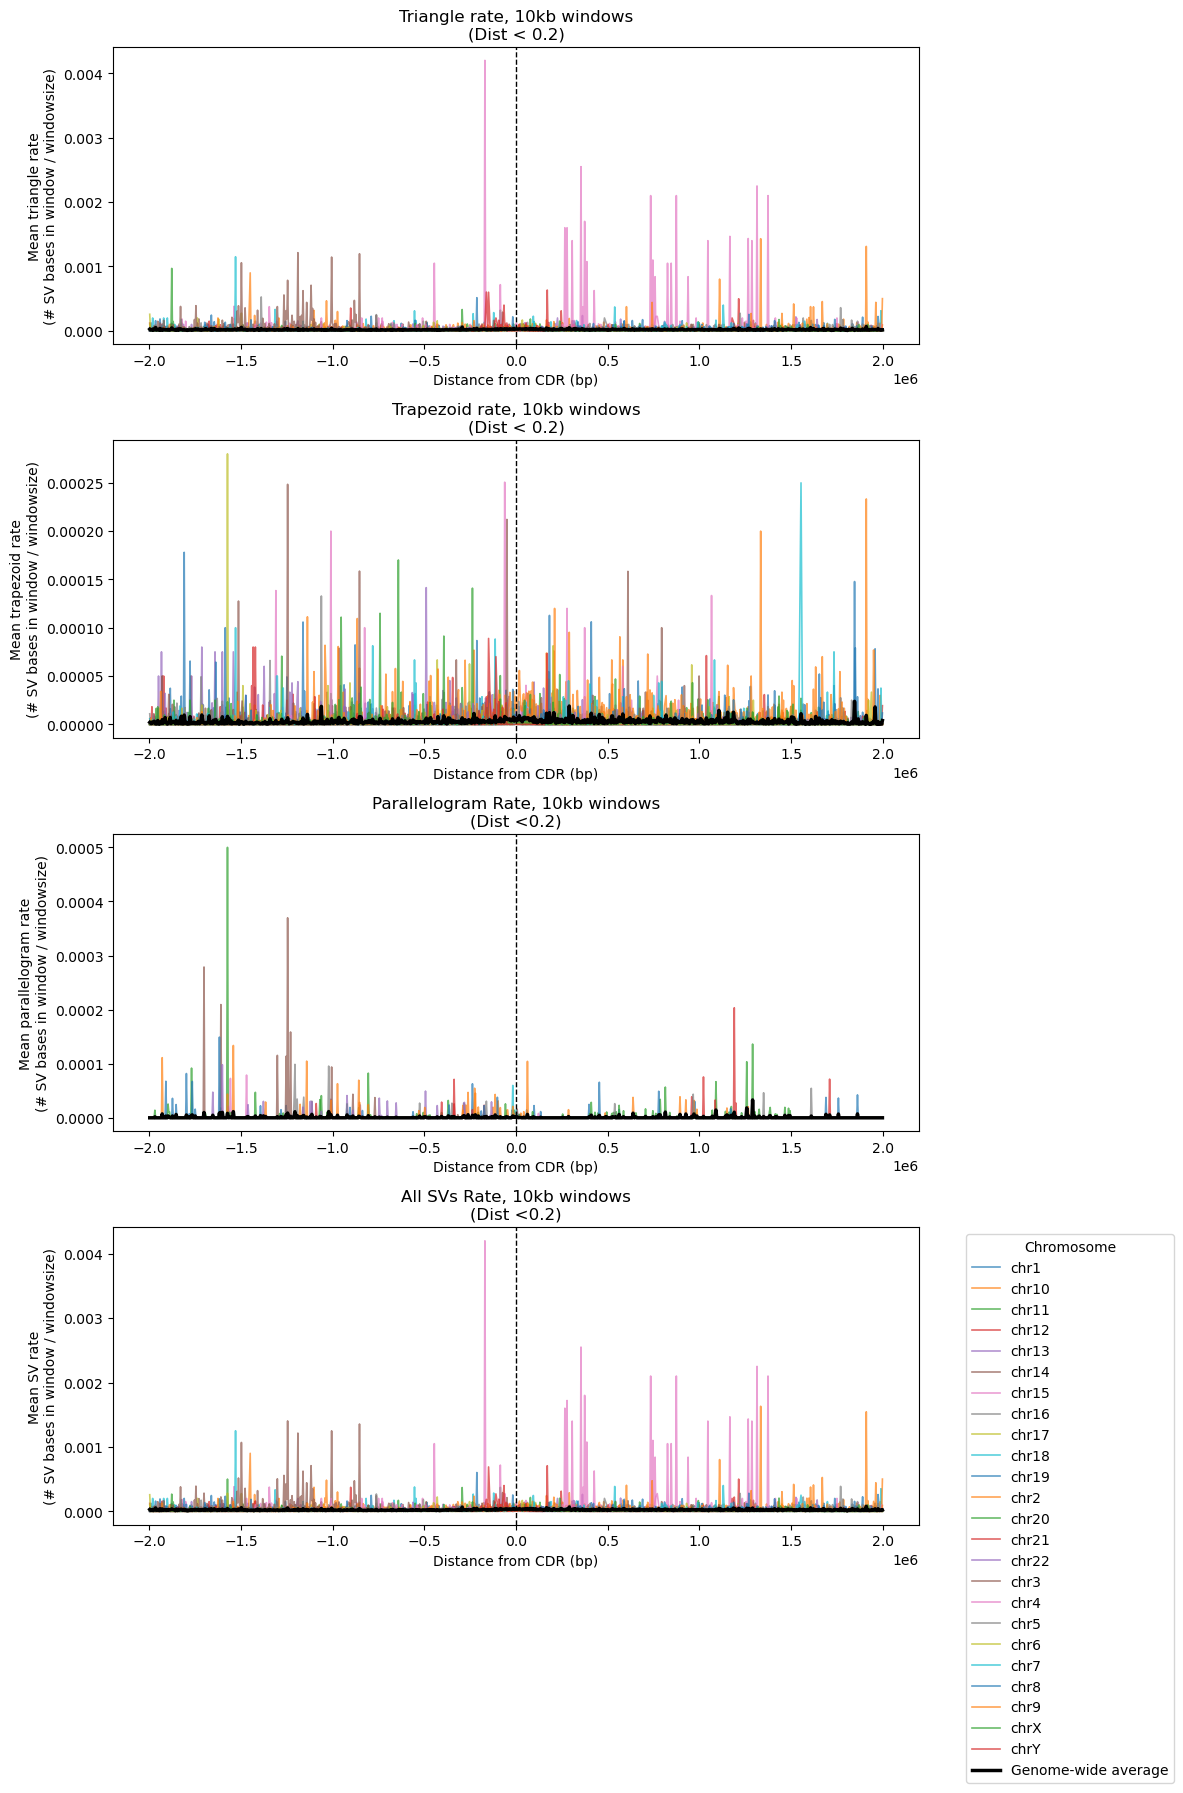

In [22]:
### Short indels mutation rate - 10kb windows
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Define bins and bin centers
window_range = 2_000_000
n_bins = 1000
bin_width = (2 * window_range) / n_bins  # 4000 bp

bin_centers = np.arange(
    -window_range + bin_width / 2,
    window_range,
    bin_width
)

bins = np.concatenate([
    bin_centers - bin_width / 2,
    [bin_centers[-1] + bin_width / 2]
])

# 2. Filter and assign bins
df = final_short_indel_10kb_df[final_short_indel_10kb_df["CDR_start"] != -1].copy()

df["distance_bin"] = pd.cut(
    df["CDR_distance"],
    bins=bins,
    labels=bin_centers,
    include_lowest=True
).astype(float)

# 3. Define rate columns and manual titles
rate_columns = ["tri_rate", "trap_rate", "par_rate", "all_rate"]
plot_titles = ["Triangle rate, 10kb windows\n(Dist < 0.2)", "Trapezoid rate, 10kb windows\n(Dist < 0.2)", "Parallelogram Rate, 10kb windows\n(Dist <0.2)", "All SVs Rate, 10kb windows\n(Dist <0.2)"]
y_labels = ["Mean triangle rate\n(# SV bases in window / windowsize)", "Mean trapezoid rate\n(# SV bases in window / windowsize)", "Mean parallelogram rate\n(# SV bases in window / windowsize)", "Mean SV rate\n(# SV bases in window / windowsize)"]

# 4. Create subplots
fig, axes = plt.subplots(len(rate_columns), 1, figsize=(12, 18))

for ax, rate_col, title, y_label in zip(axes, rate_columns, plot_titles, y_labels):

    # Aggregate per chromosome
    agg = (
        df
        .groupby(["chr", "distance_bin"], as_index=False)
        .agg(mean_rate=(rate_col, "mean"))
    )

    # Aggregate genome-wide
    genome_avg = (
        df
        .groupby("distance_bin", as_index=False)
        .agg(mean_rate=(rate_col, "mean"))
        .sort_values("distance_bin")
    )

    # Per-chromosome lines
    for chrom, chrom_df in agg.groupby("chr"):
        chrom_df = chrom_df.sort_values("distance_bin")
        ax.plot(
            chrom_df["distance_bin"],
            chrom_df["mean_rate"],
            label=str(chrom),
            linewidth=1.2,
            alpha=0.7
        )

    # Genome-wide average (black, thick, on top)
    ax.plot(
        genome_avg["distance_bin"],
        genome_avg["mean_rate"],
        color="black",
        linewidth=2.5,
        label="Genome-wide average",
        zorder=10
    )

    ax.axvline(0, color="black", linestyle="--", linewidth=1)
    ax.set_ylabel(y_label)
    ax.set_xlabel("Distance from CDR (bp)")
    ax.set_title(title)  # Manually set title here

# Legend on the last subplot
axes[-1].legend(title="Chromosome", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

### all SNVs (raw), 1000 bp windows 

In [31]:
def load_matching_beds_SNVs(chr_str, bed_folder, pairs_df, suffix):

    valid_pairs = {
        frozenset((row.sample1, row.sample2))
        for _, row in pairs_df.iterrows()
    }

    col_indices = [0, 1, 2, 3, 6, 7, 8, 9,10,16]
    col_names = [
        "contig",
        "window_start",
        "window_end",
        "SNV_counts",
        "SNV_rate",
        "CDR_contig",
        "CDR_start",
        "CDR_end",
        "CDR_status",
        "CDR_distance"
    ]

    all_beds = []

    for fname in os.listdir(bed_folder):

        if not fname.endswith(suffix):
            continue

        base = fname.replace(suffix, "")
        try:
            s1, s2 = base.split("_", 1)
        except ValueError:
            continue

        if frozenset((s1, s2)) not in valid_pairs:
            continue

        bed_path = os.path.join(bed_folder, fname)

        bed_df = pd.read_csv(
            bed_path,
            sep="\t",
            header=None
        )

        #if bed_df.shape[1] <= max(col_indices):
            #print("Unexpected column count:", bed_path, bed_df.shape[1])
            #continue

        # Subset columns
        bed_df = bed_df.iloc[:, col_indices]

        if bed_df.empty:
            continue

        # Add sample metadata
        bed_df.columns = col_names
        bed_df["sample1"] = s1
        bed_df["sample2"] = s2
        bed_df["chr"]=chr_str

        # Check whether all rows have CDR_status == "CDR". Might use this to filter out pairs where one pair doesn't have CDR annotations
        # to make the counts work out 

        both_pairs_CDR = bed_df["CDR_status"].eq("CDR").all()
        bed_df["both_pairs_CDR"] = both_pairs_CDR

        all_beds.append(bed_df)

    if not all_beds:
        return pd.DataFrame()

    return pd.concat(all_beds, ignore_index=True)

In [ ]:
bed_paths="/private/groups/patenlab/mira/centrolign/analysis/variant_dist_CDR/SNVs_pairwise_raw/1kb/"

# Define chromosomes
chroms = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
#chroms=["chrY"]
all_chrom_dfs = []

for chrom in chroms:

    # Subset pairs dataframe for this chromosome
    pairs_chr_df = all_pairs_dist_df[
        (all_pairs_dist_df["chr"] == chrom) &
        (all_pairs_dist_df["direct_pairwise_dist"] < 0.2)
    ]

    if pairs_chr_df.empty:
        continue
    
    print(f"Processing {chrom}...")
    # Load matching BED data for this chromosome

    chrom_df = load_matching_beds_SNVs(
        chr_str=chrom,
        bed_folder=bed_paths+chrom,
        pairs_df=pairs_chr_df,
        suffix=".CDR_dist.1kb.bed"
    )

    if not chrom_df.empty:
        chrom_df["chr"] = chrom  # optional, but often useful
        all_chrom_dfs.append(chrom_df)

# Concatenate all chromosomes into one DataFrame
final_SNV_raw_1000bp_df = pd.concat(all_chrom_dfs, ignore_index=True)



final_SNV_raw_1000bp_df.head()

Processing chr1...
Processing chr2...
Processing chr3...
Processing chr4...
Processing chr5...
Processing chr6...
Processing chr7...
Processing chr8...
Processing chr9...
Processing chr10...
Processing chr11...
Processing chr12...
Processing chr13...
Processing chr14...
Processing chr15...
Processing chr16...
Processing chr17...
Processing chr18...
Processing chr19...
Processing chr20...
Processing chr21...
Processing chr22...
Processing chrX...
Processing chrY...


contig  window_start  window_end  SNV_counts  \
0  HG01175#2#JAHALZ020000037.1     121382494   121383494           1   
1  HG01175#2#JAHALZ020000037.1     121383494   121384494           0   
2  HG01175#2#JAHALZ020000037.1     121384494   121385494           1   
3  HG01175#2#JAHALZ020000037.1     121385494   121386494           0   
4  HG01175#2#JAHALZ020000037.1     121386494   121387494           0   

   SNV_rate                   CDR_contig  CDR_start    CDR_end CDR_status  \
0     0.001  HG01175#2#JAHALZ020000037.1  122083249  122092322        CDR   
1     0.000  HG01175#2#JAHALZ020000037.1  122083249  122092322        CDR   
2     0.001  HG01175#2#JAHALZ020000037.1  122083249  122092322        CDR   
3     0.000  HG01175#2#JAHALZ020000037.1  122083249  122092322        CDR   
4     0.000  HG01175#2#JAHALZ020000037.1  122083249  122092322        CDR   

   CDR_distance    sample1    sample2   chr  both_pairs_CDR  
0        699756  HG01175.2  NA19159.2  chr1           False  
1        698756  HG01175.2  NA19159.2  chr1           False  
2        697756  HG01175.2  NA19159.2  chr1           False  
3        696756  HG01175.2  NA19159.2  chr1           False  
4        695756  HG01175.2  NA19159.2  chr1           False

In [58]:
# REVERSE CDR COORDS to match neg to upstream and pos to downstream
final_SNV_raw_1000bp_df["CDR_distance"] = -final_SNV_raw_1000bp_df["CDR_distance"]

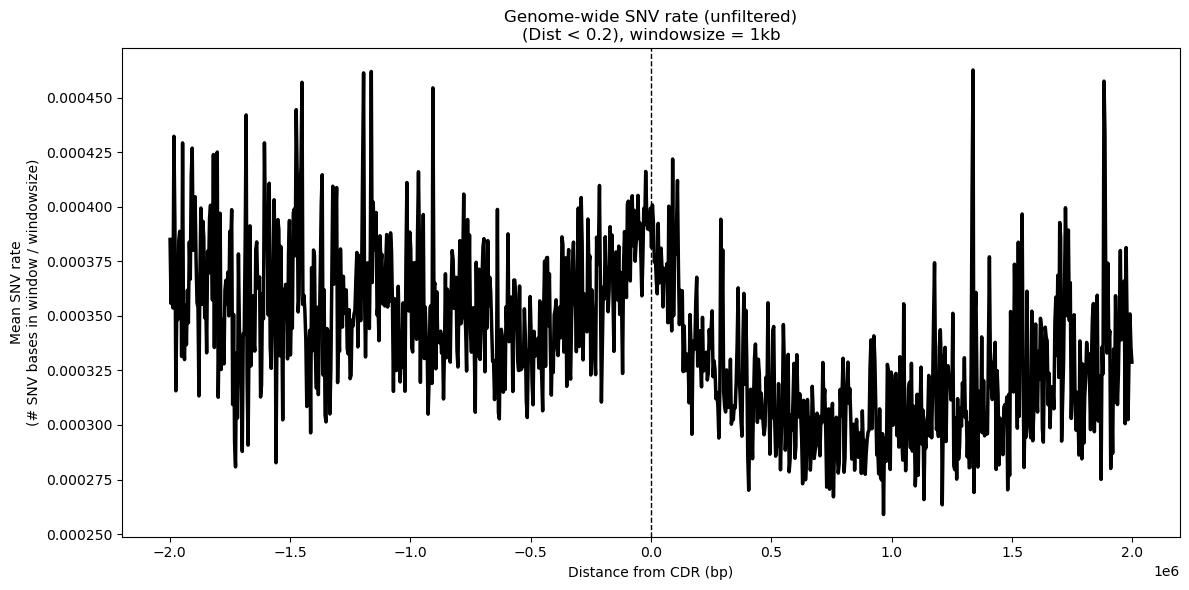

In [59]:
### SNVs mutation rate - 1000bp windows
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Define bins and bin centers
window_range = 2_000_000
n_bins = 1000
bin_width = (2 * window_range) / n_bins  # 4000 bp

bin_centers = np.arange(
    -window_range + bin_width / 2,
    window_range,
    bin_width
)

bins = np.concatenate([
    bin_centers - bin_width / 2,
    [bin_centers[-1] + bin_width / 2]
])

# 2. Filter and assign bins
df = final_SNV_raw_1000bp_df[final_SNV_raw_1000bp_df["CDR_start"] != -1].copy()

df["distance_bin"] = pd.cut(
    df["CDR_distance"],
    bins=bins,
    labels=bin_centers,
    include_lowest=True
).astype(float)

# 3. Plot settings (single plot)
rate_col = "SNV_rate"
title = "Genome-wide SNV rate (unfiltered)\n(Dist < 0.2), windowsize = 1kb"
y_label = "Mean SNV rate\n(# SNV bases in window / windowsize)"

# 4. Compute genome-wide average
genome_avg = (
    df
    .groupby("distance_bin", as_index=False)
    .agg(mean_rate=(rate_col, "mean"))
    .sort_values("distance_bin")
)

# 5. Create ONE plot
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(
    genome_avg["distance_bin"],
    genome_avg["mean_rate"],
    color="black",
    linewidth=2.5
)

ax.axvline(0, color="black", linestyle="--", linewidth=1)
ax.set_ylabel(y_label)
ax.set_xlabel("Distance from CDR (bp)")
ax.set_title(title)

plt.tight_layout()
plt.show()



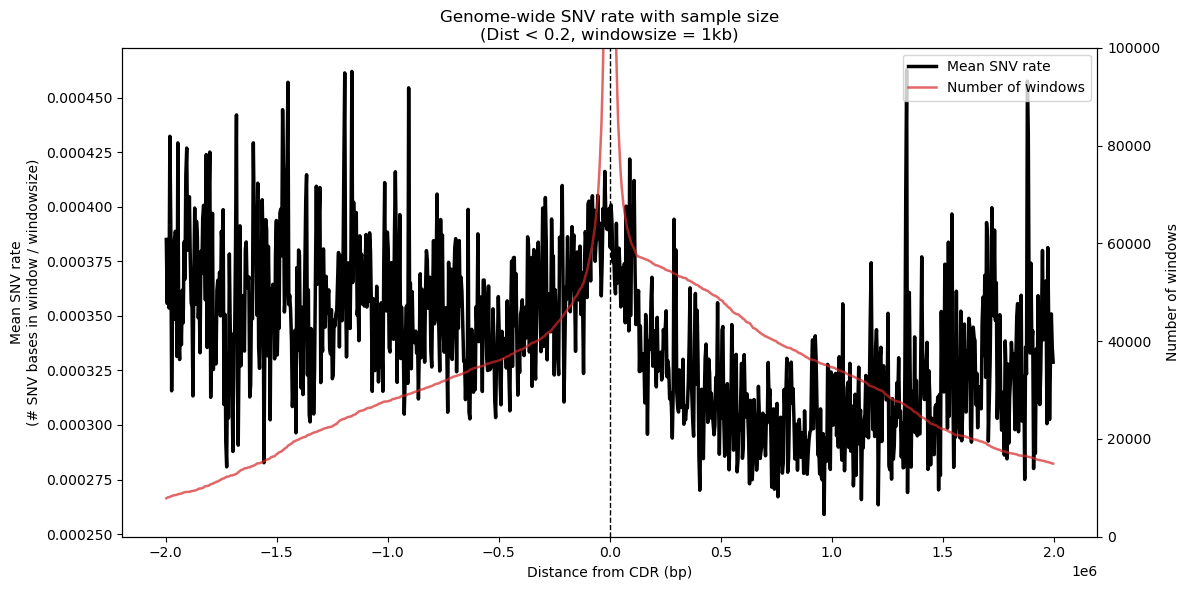

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Define bins and bin centers
window_range = 2_000_000
n_bins = 1000
bin_width = (2 * window_range) / n_bins  # 4000 bp

bin_centers = np.arange(
    -window_range + bin_width / 2,
    window_range,
    bin_width
)

bins = np.concatenate([
    bin_centers - bin_width / 2,
    [bin_centers[-1] + bin_width / 2]
])

# 2. Filter and assign bins
df = final_SNV_raw_1000bp_df[final_SNV_raw_1000bp_df["CDR_start"] != -1].copy()

df["distance_bin"] = pd.cut(
    df["CDR_distance"],
    bins=bins,
    labels=bin_centers,
    include_lowest=True
).astype(float)

# 3. Aggregate: mean rate + sample size (ALL bins)
summary = (
    df
    .groupby("distance_bin", as_index=False)
    .agg(
        mean_rate=("SNV_rate", "mean"),
        n_windows=("SNV_rate", "size")
    )
    .sort_values("distance_bin")
)

# 4. Create plot with secondary y-axis
fig, ax = plt.subplots(figsize=(12, 6))
ax2 = ax.twinx()

# Primary axis: SNV rate (includes 0 bin)
ax.plot(
    summary["distance_bin"],
    summary["mean_rate"],
    color="black",
    linewidth=2.5,
    label="Mean SNV rate"
)

# Secondary axis: sample size (EXCLUDE 0 bin ONLY HERE)
summary_no_zero = summary[summary["distance_bin"] != 0]

ax2.plot(
    summary_no_zero["distance_bin"],
    summary_no_zero["n_windows"],
    color="tab:red",
    linewidth=1.8,
    alpha=0.7,
    label="Number of windows"
)

# Formatting
ax.axvline(0, color="black", linestyle="--", linewidth=1)
ax.set_xlabel("Distance from CDR (bp)")
ax.set_ylabel("Mean SNV rate\n(# SNV bases in window / windowsize)")
ax2.set_ylabel("Number of windows")

ax.set_title(
    "Genome-wide SNV rate with sample size\n"
    "(Dist < 0.2, windowsize = 1kb)"
)

# Combined legend
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc="upper right")
ax2.set_ylim(0,100000)

plt.tight_layout()
plt.show()


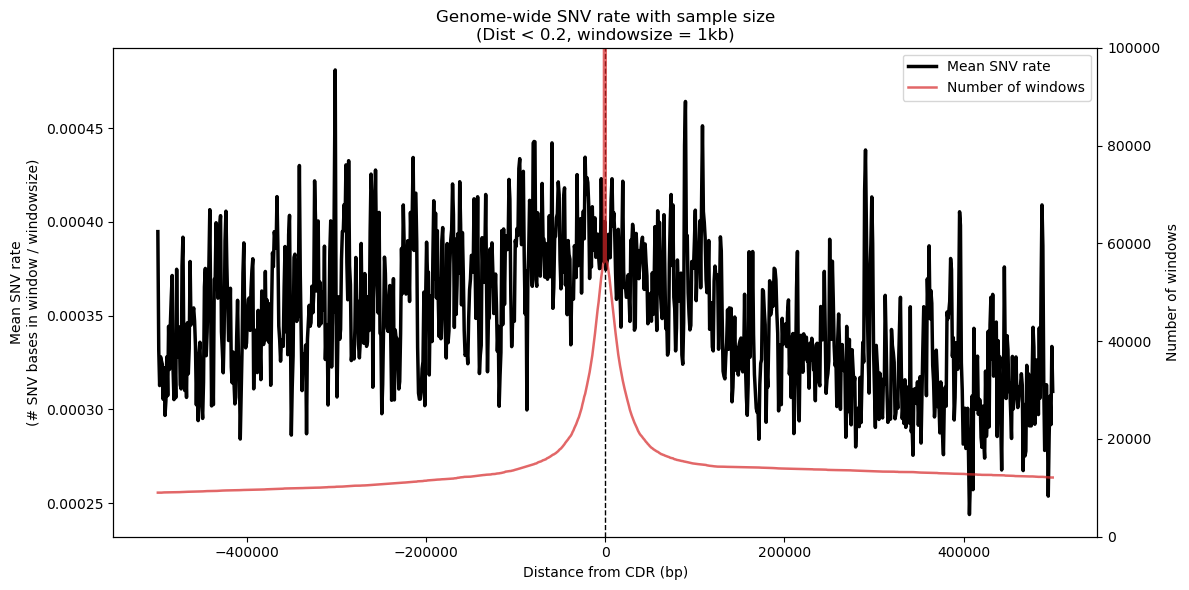

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Define bins and bin centers
window_range = 500_000
n_bins = 1000
bin_width = (2 * window_range) / n_bins  # 4000 bp

bin_centers = np.arange(
    -window_range + bin_width / 2,
    window_range,
    bin_width
)

bins = np.concatenate([
    bin_centers - bin_width / 2,
    [bin_centers[-1] + bin_width / 2]
])

# 2. Filter and assign bins
df = final_SNV_raw_1000bp_df[final_SNV_raw_1000bp_df["CDR_start"] != -1].copy()

df["distance_bin"] = pd.cut(
    df["CDR_distance"],
    bins=bins,
    labels=bin_centers,
    include_lowest=True
).astype(float)

# 3. Aggregate: mean rate + sample size (ALL bins)
summary = (
    df
    .groupby("distance_bin", as_index=False)
    .agg(
        mean_rate=("SNV_rate", "mean"),
        n_windows=("SNV_rate", "size")
    )
    .sort_values("distance_bin")
)

# 4. Create plot with secondary y-axis
fig, ax = plt.subplots(figsize=(12, 6))
ax2 = ax.twinx()

# Primary axis: SNV rate (includes 0 bin)
ax.plot(
    summary["distance_bin"],
    summary["mean_rate"],
    color="black",
    linewidth=2.5,
    label="Mean SNV rate"
)

# Secondary axis: sample size (EXCLUDE 0 bin ONLY HERE)
summary_no_zero = summary[summary["distance_bin"] != 0]

ax2.plot(
    summary_no_zero["distance_bin"],
    summary_no_zero["n_windows"],
    color="tab:red",
    linewidth=1.8,
    alpha=0.7,
    label="Number of windows"
)

# Formatting
ax.axvline(0, color="black", linestyle="--", linewidth=1)
ax.set_xlabel("Distance from CDR (bp)")
ax.set_ylabel("Mean SNV rate\n(# SNV bases in window / windowsize)")
ax2.set_ylabel("Number of windows")

ax.set_title(
    "Genome-wide SNV rate with sample size\n"
    "(Dist < 0.2, windowsize = 1kb)"
)

# Combined legend
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc="upper right")
ax2.set_ylim(0,100000)

plt.tight_layout()
plt.show()


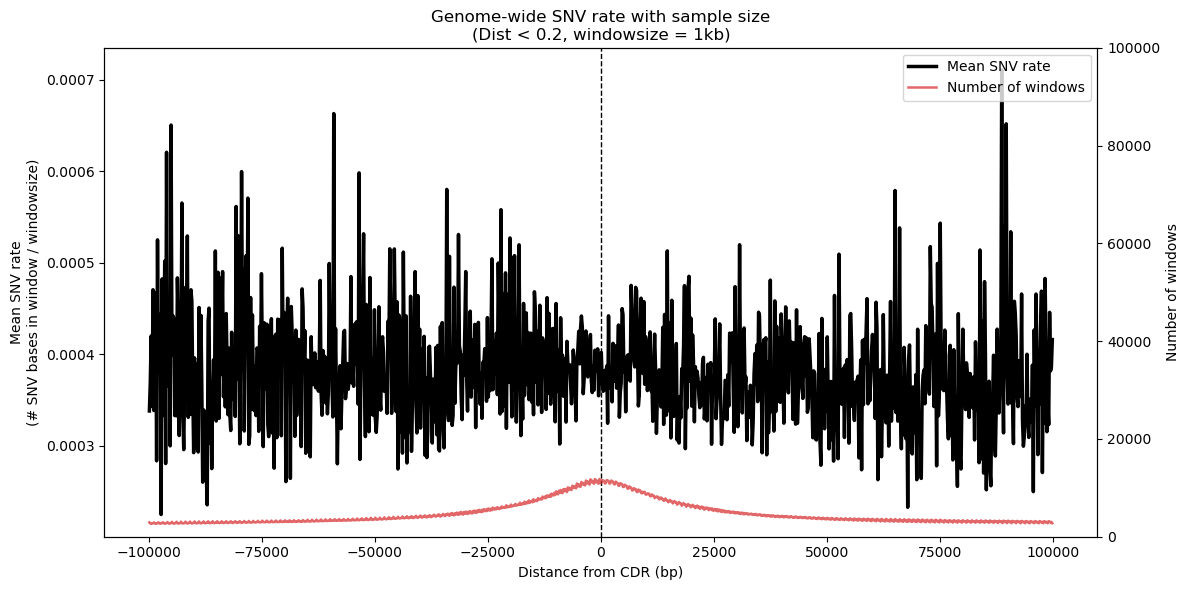

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Define bins (EXCLUDING zero)
window_range = 100_000
n_bins = 1000
bin_width = (2 * window_range) / n_bins  # 1000 bp

bin_edges = np.linspace(-window_range, window_range, n_bins + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# 2. Filter data
df = final_SNV_raw_1000bp_df[
    final_SNV_raw_1000bp_df["CDR_start"] != -1
].copy()

# 3. Split zero vs non-zero distances
df_zero = df[df["CDR_distance"] == 0].copy()
df_nonzero = df[df["CDR_distance"] != 0].copy()

# Assign bins
df_zero["distance_bin"] = 0

df_nonzero["distance_bin"] = pd.cut(
    df_nonzero["CDR_distance"],
    bins=bin_edges,
    labels=bin_centers,
    include_lowest=True
).astype(float)

# Recombine
df_binned = pd.concat([df_zero, df_nonzero], ignore_index=True)

# 4. Aggregate
summary = (
    df_binned
    .groupby("distance_bin", as_index=False)
    .agg(
        mean_rate=("SNV_rate", "mean"),
        n_windows=("SNV_rate", "size")
    )
    .sort_values("distance_bin")
)

# 5. Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax2 = ax.twinx()

# Mean SNV rate (includes zero bin)
ax.plot(
    summary["distance_bin"],
    summary["mean_rate"],
    color="black",
    linewidth=2.5,
    label="Mean SNV rate"
)

# Sample size (exclude zero bin only for visibility)
summary_no_zero = summary[summary["distance_bin"] != 0]

ax2.plot(
    summary_no_zero["distance_bin"],
    summary_no_zero["n_windows"],
    color="tab:red",
    linewidth=1.8,
    alpha=0.7,
    label="Number of windows"
)

# Formatting
ax.axvline(0, color="black", linestyle="--", linewidth=1)
ax.set_xlabel("Distance from CDR (bp)")
ax.set_ylabel("Mean SNV rate\n(# SNV bases in window / windowsize)")
ax2.set_ylabel("Number of windows")

ax.set_title(
    "Genome-wide SNV rate with sample size\n"
    "(Dist < 0.2, windowsize = 1kb)"
)

lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc="upper right")
ax2.set_ylim(0, 100000)

plt.tight_layout()
plt.show()


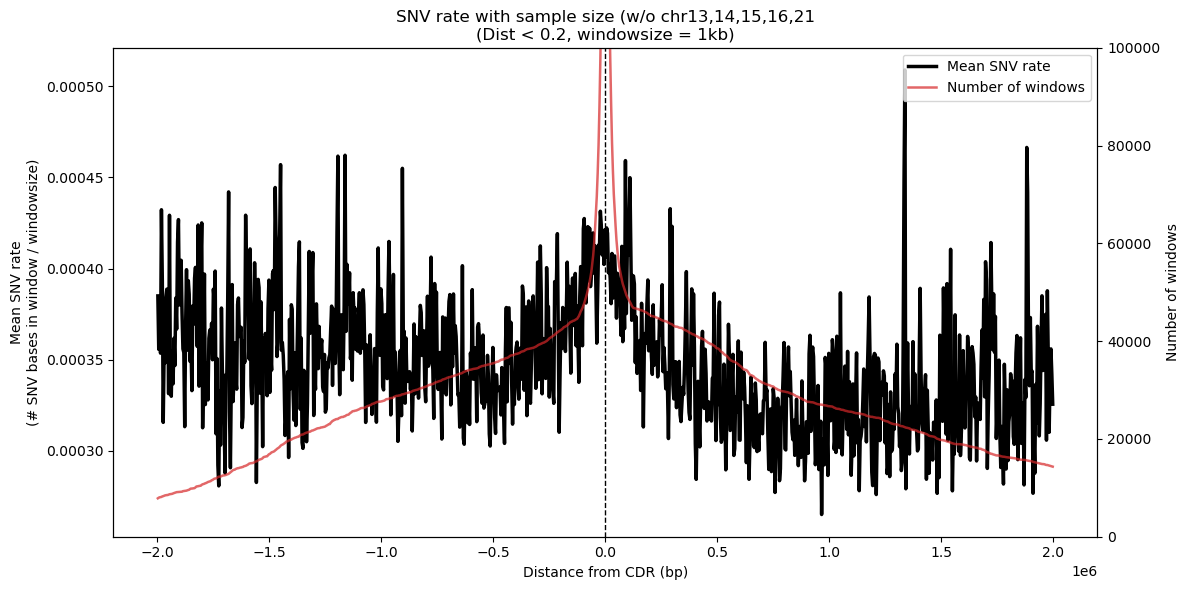

In [61]:
# Genome wide SNV rate removing the chroms with dropout

### SNVs mutation rate - 1000bp windows
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Define bins and bin centers
window_range = 2_000_000
n_bins = 1000
bin_width = (2 * window_range) / n_bins  # 4000 bp

bin_centers = np.arange(
    -window_range + bin_width / 2,
    window_range,
    bin_width
)

bins = np.concatenate([
    bin_centers - bin_width / 2,
    [bin_centers[-1] + bin_width / 2]
])

# 2. Filter and assign bins
df = final_SNV_raw_1000bp_df[
    (final_SNV_raw_1000bp_df["CDR_start"] != -1) &
    (~final_SNV_raw_1000bp_df["chr"].isin(["chr13", "chr14","chr15", "chr16", "chr21"]))
].copy()


df["distance_bin"] = pd.cut(
    df["CDR_distance"],
    bins=bins,
    labels=bin_centers,
    include_lowest=True
).astype(float)

# 3. Aggregate: mean rate + sample size (ALL bins)
summary = (
    df
    .groupby("distance_bin", as_index=False)
    .agg(
        mean_rate=("SNV_rate", "mean"),
        n_windows=("SNV_rate", "size")
    )
    .sort_values("distance_bin")
)

# 4. Create plot with secondary y-axis
fig, ax = plt.subplots(figsize=(12, 6))
ax2 = ax.twinx()

# Primary axis: SNV rate (includes 0 bin)
ax.plot(
    summary["distance_bin"],
    summary["mean_rate"],
    color="black",
    linewidth=2.5,
    label="Mean SNV rate"
)

# Secondary axis: sample size (EXCLUDE 0 bin ONLY HERE)
summary_no_zero = summary[summary["distance_bin"] != 0]

ax2.plot(
    summary_no_zero["distance_bin"],
    summary_no_zero["n_windows"],
    color="tab:red",
    linewidth=1.8,
    alpha=0.7,
    label="Number of windows"
)

# Formatting
ax.axvline(0, color="black", linestyle="--", linewidth=1)
ax.set_xlabel("Distance from CDR (bp)")
ax.set_ylabel("Mean SNV rate\n(# SNV bases in window / windowsize)")
ax2.set_ylabel("Number of windows")

ax.set_title(
    "SNV rate with sample size (w/o chr13,14,15,16,21\n"
    "(Dist < 0.2, windowsize = 1kb)"
)

# Combined legend
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc="upper right")
ax2.set_ylim(0,100000)

plt.tight_layout()
plt.show()

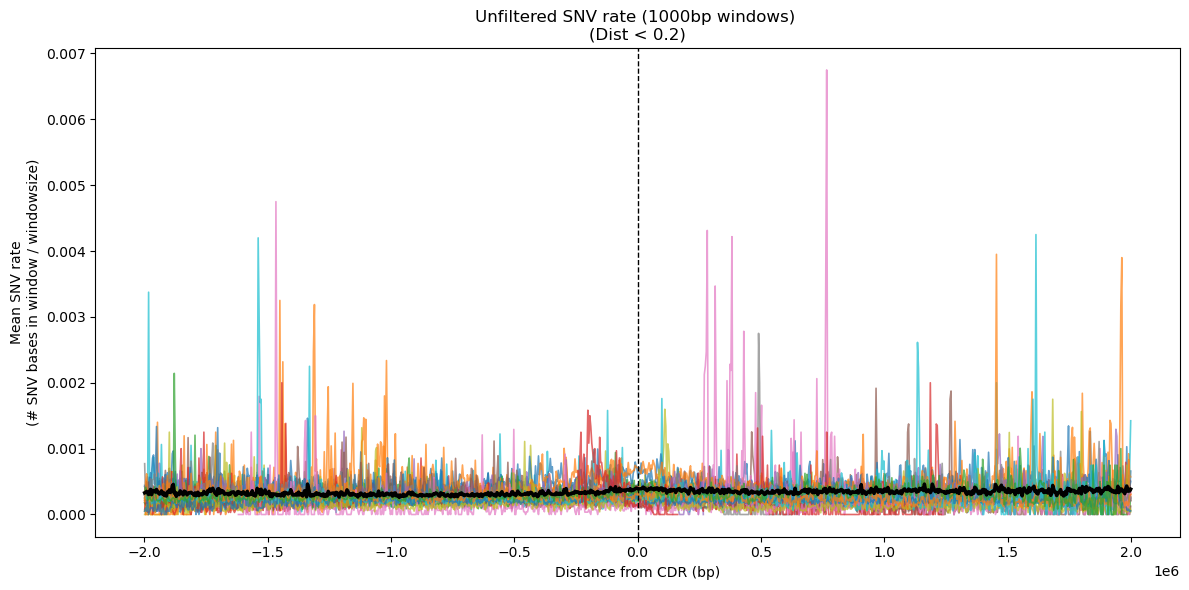

In [ ]:
### Short indels mutation rate - 1000bp windows
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Define bins and bin centers
window_range = 2_000_000
n_bins = 1000
bin_width = (2 * window_range) / n_bins  # 4000 bp

bin_centers = np.arange(
    -window_range + bin_width / 2,
    window_range,
    bin_width
)

bins = np.concatenate([
    bin_centers - bin_width / 2,
    [bin_centers[-1] + bin_width / 2]
])

# 2. Filter and assign bins
df = final_SNV_raw_1000bp_df[final_SNV_raw_1000bp_df["CDR_start"] != -1].copy()

df["distance_bin"] = pd.cut(
    df["CDR_distance"],
    bins=bins,
    labels=bin_centers,
    include_lowest=True
).astype(float)

# 5. Create ONE plot
fig, ax = plt.subplots(figsize=(12, 6))

agg = (
        df
        .groupby(["chr", "distance_bin"], as_index=False)
        .agg(mean_rate=("SNV_rate", "mean"))
    )

    # Aggregate genome-wide
genome_avg = (
        df
        .groupby("distance_bin", as_index=False)
        .agg(mean_rate=("SNV_rate", "mean"))
        .sort_values("distance_bin")
    )

    # Per-chromosome lines
for chrom, chrom_df in agg.groupby("chr"):
        chrom_df = chrom_df.sort_values("distance_bin")
        ax.plot(
            chrom_df["distance_bin"],
            chrom_df["mean_rate"],
            label=str(chrom),
            linewidth=1.2,
            alpha=0.7
        )

    # Genome-wide average (black, thick, on top)
ax.plot(
        genome_avg["distance_bin"],
        genome_avg["mean_rate"],
        color="black",
        linewidth=2.5,
        label="Genome-wide average",
        zorder=10
    )

ax.axvline(0, color="black", linestyle="--", linewidth=1)
ax.set_ylabel("Mean SNV rate\n(# SNV bases in window / windowsize)")
ax.set_xlabel("Distance from CDR (bp)")
ax.set_title("Unfiltered SNV rate (1000bp windows) \n(Dist < 0.2)")  # Manually set title here

# Legend on the last subplot
axes[-1].legend(title="Chromosome", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

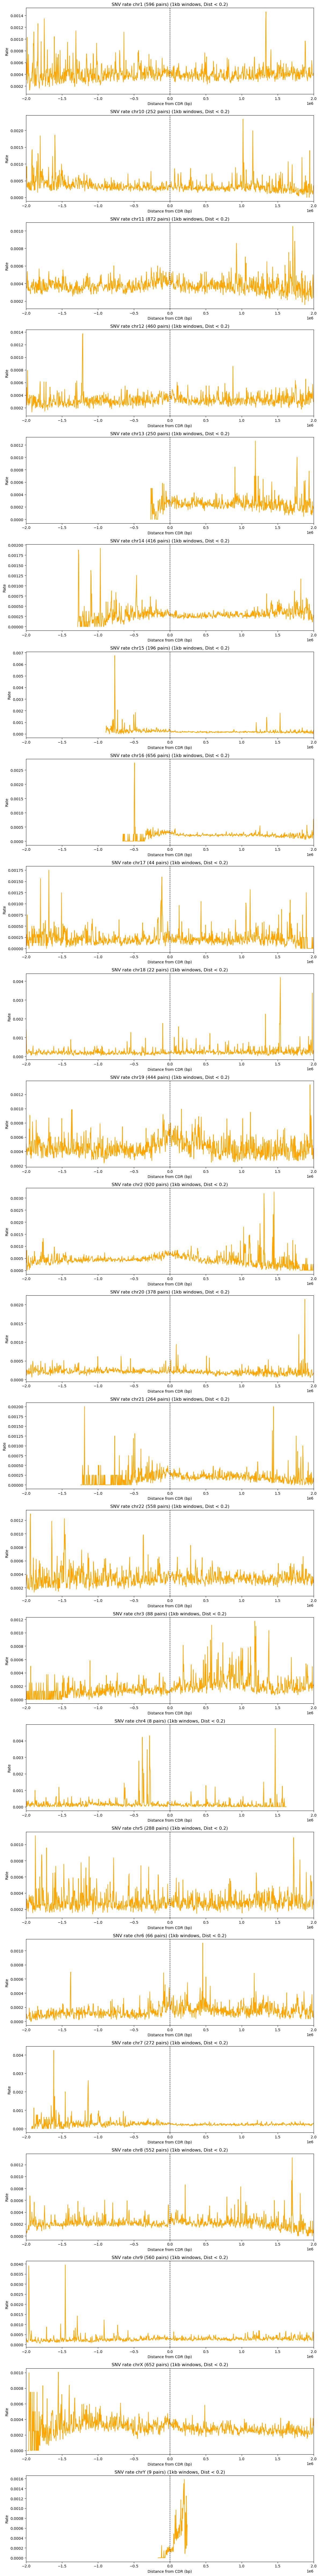

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Filter for valid CDR positions
df = final_SNV_raw_1000bp_df[final_SNV_raw_1000bp_df["CDR_start"] != -1].copy()

# Define bins and bin centers
window_range = 2_000_000
n_bins = 1000
bin_width = (2 * window_range) / n_bins

bin_centers = np.arange(
    -window_range + bin_width / 2,
    window_range,
    bin_width
)

bins = np.concatenate([
    bin_centers - bin_width / 2,
    [bin_centers[-1] + bin_width / 2]
])

# Assign each row to a distance bin
df["distance_bin"] = pd.cut(
    df["CDR_distance"],
    bins=bins,
    labels=bin_centers,
    include_lowest=True
).astype(float)

# List of chromosomes
chromosomes = sorted(df["chr"].unique())

# Count unique sample pairs per chromosome
pair_counts = (
    df[["chr", "sample1", "sample2"]]
    .drop_duplicates()
    .groupby("chr")
    .size()
    .to_dict()
)

# Create subplots: one panel per chromosome
fig, axes = plt.subplots(len(chromosomes), 1, figsize=(12, 4 * len(chromosomes)))

if len(chromosomes) == 1:
    axes = [axes]

for ax, chrom in zip(axes, chromosomes):
    chrom_df = df[df["chr"] == chrom]

    for rate_col in ["SNV_rate"]:
        agg = (
            chrom_df
            .groupby("distance_bin", as_index=False)
            .agg(mean_rate=(rate_col, "mean"))
            .sort_values("distance_bin")
        )
        ax.plot(
            agg["distance_bin"],
            agg["mean_rate"],
            color="orange",
            linewidth=1.5
        )

    # Plot ALL rate in black, thicker line
    agg_all = (
        chrom_df
        .groupby("distance_bin", as_index=False)
        .agg(mean_rate=("SNV_rate", "mean"))
        .sort_values("distance_bin")
    )
    # ax.plot(
    #     agg_all["distance_bin"],
    #     agg_all["mean_rate"],
    #     color=rate_colors["all_rate"],
    #     linewidth=1.5,
    #     label="All Rate",
    #     zorder=10
    # )

    # Vertical line at CDR
    ax.axvline(0, color="black", linestyle="--", linewidth=1)

    # Axis limits, labels, title
    ax.set_ylabel("Rate")
    ax.set_xlim(-2000000, 2000000)
    n_pairs = pair_counts.get(chrom, 0)
    ax.set_title(f"SNV rate {chrom} ({n_pairs} pairs) (1kb windows, Dist < 0.2)")

    # x-axis label for the bottom panel
    ax.set_xlabel("Distance from CDR (bp)")

# Legend on the top panel
#axes[0].legend(title="Rates", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

### Filtered SNV rates 

In [6]:
bed_paths="/private/groups/patenlab/mira/centrolign/analysis/variant_dist_CDR/SNVs_pairwise_filt/1kb/"

# Define chromosomes
chroms = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
#chroms=["chrY"]
all_chrom_dfs = []

for chrom in chroms:

    # Subset pairs dataframe for this chromosome
    pairs_chr_df = all_pairs_dist_df[
        (all_pairs_dist_df["chr"] == chrom) &
        (all_pairs_dist_df["direct_pairwise_dist"] < 0.2)
    ]

    if pairs_chr_df.empty:
        continue
    
    print(f"Processing {chrom}...")
    # Load matching BED data for this chromosome

    chrom_df = load_matching_beds_SNVs(
        chr_str=chrom,
        bed_folder=bed_paths+chrom,
        pairs_df=pairs_chr_df,
        suffix=".snvs.500bp_95pct.CDR_dist.1kb.bed"
    )

    if not chrom_df.empty:
        chrom_df["chr"] = chrom  # optional, but often useful
        all_chrom_dfs.append(chrom_df)

# Concatenate all chromosomes into one DataFrame
final_SNV_10bp_95pct_1kb_df = pd.concat(all_chrom_dfs, ignore_index=True)

final_SNV_10bp_95pct_1kb_df.head()

Processing chr1...
Processing chr2...
Processing chr3...
Processing chr4...
Processing chr5...
Processing chr6...
Processing chr7...
Processing chr8...
Processing chr9...
Processing chr10...
Processing chr11...
Processing chr12...
Processing chr13...
Processing chr14...
Processing chr15...
Processing chr16...
Processing chr17...
Processing chr18...
Processing chr19...
Processing chr20...
Processing chr21...
Processing chr22...
Processing chrX...
Processing chrY...


contig  window_start  window_end  SNV_counts  \
0  HG01192#1#JBHDVI010000055.1     120584625   120585625           0   
1  HG01192#1#JBHDVI010000055.1     120585625   120586625           1   
2  HG01192#1#JBHDVI010000055.1     120586625   120587625           0   
3  HG01192#1#JBHDVI010000055.1     120587625   120588625           0   
4  HG01192#1#JBHDVI010000055.1     120588625   120589625           0   

   SNV_rate                   CDR_contig  CDR_start    CDR_end CDR_status  \
0     0.000  HG01192#1#JBHDVI010000055.1  121349453  121380578        CDR   
1     0.001  HG01192#1#JBHDVI010000055.1  121349453  121380578        CDR   
2     0.000  HG01192#1#JBHDVI010000055.1  121349453  121380578        CDR   
3     0.000  HG01192#1#JBHDVI010000055.1  121349453  121380578        CDR   
4     0.000  HG01192#1#JBHDVI010000055.1  121349453  121380578        CDR   

   CDR_distance    sample1    sample2   chr  both_pairs_CDR  
0        763829  HG01943.2  HG01192.1  chr1            True  
1        762829  HG01943.2  HG01192.1  chr1            True  
2        761829  HG01943.2  HG01192.1  chr1            True  
3        760829  HG01943.2  HG01192.1  chr1            True  
4        759829  HG01943.2  HG01192.1  chr1            True

In [ ]:
# REVERSE CDR COORDS to match neg to upstream and pos to downstream
final_SNV_10bp_95pct_1kb_df["CDR_distance"] = -final_SNV_10bp_95pct_1kb_df["CDR_distance"]

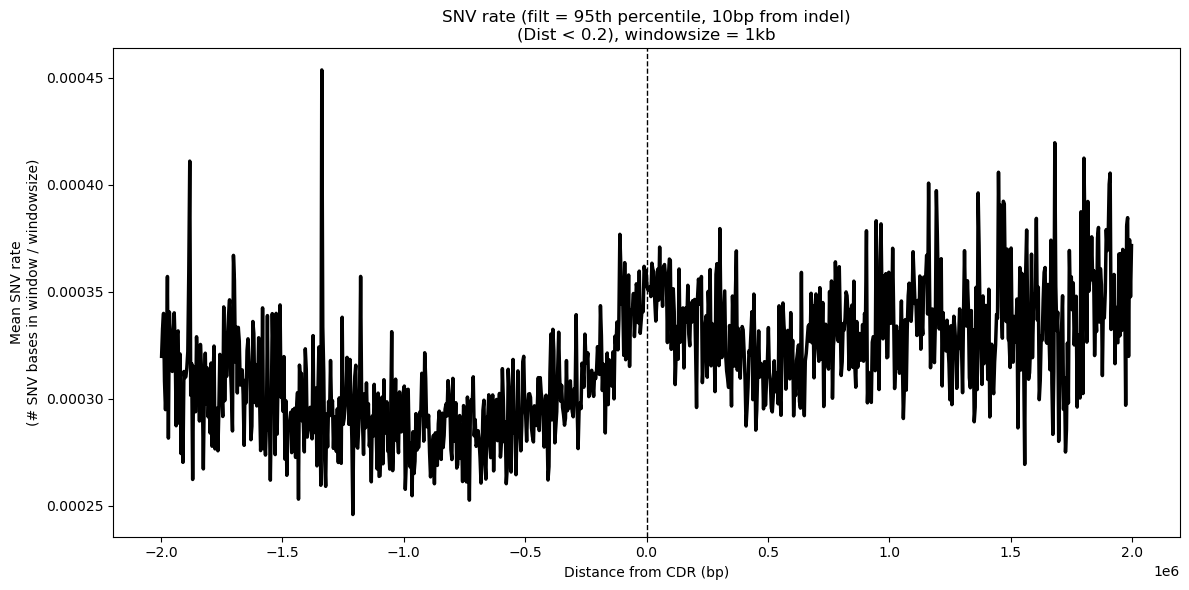

In [5]:
### Short indels mutation rate - 100bp windows
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Define bins and bin centers
window_range = 2_000_000
n_bins = 1000
bin_width = (2 * window_range) / n_bins  # 4000 bp

bin_centers = np.arange(
    -window_range + bin_width / 2,
    window_range,
    bin_width
)

bins = np.concatenate([
    bin_centers - bin_width / 2,
    [bin_centers[-1] + bin_width / 2]
])

# 2. Filter and assign bins
df = final_SNV_10bp_95pct_1kb_df[final_SNV_10bp_95pct_1kb_df["CDR_start"] != -1].copy()

df["distance_bin"] = pd.cut(
    df["CDR_distance"],
    bins=bins,
    labels=bin_centers,
    include_lowest=True
).astype(float)

# 3. Plot settings (single plot)
rate_col = "SNV_rate"
title = "SNV rate (filt = 95th percentile, 10bp from indel)\n(Dist < 0.2), windowsize = 1kb"
y_label = "Mean SNV rate\n(# SNV bases in window / windowsize)"

# 4. Compute genome-wide average
genome_avg = (
    df
    .groupby("distance_bin", as_index=False)
    .agg(mean_rate=(rate_col, "mean"))
    .sort_values("distance_bin")
)

# 5. Create ONE plot
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(
    genome_avg["distance_bin"],
    genome_avg["mean_rate"],
    color="black",
    linewidth=2.5
)

ax.axvline(0, color="black", linestyle="--", linewidth=1)
ax.set_ylabel(y_label)
ax.set_xlabel("Distance from CDR (bp)")
ax.set_title(title)

plt.tight_layout()
plt.show()
